In [1]:
import optuna
import pandas as pd
import numpy as np
from utils.lgbm_utils import run_tuning, model_testing, get_cfps, get_bitfps
import shap
import joblib

In [2]:
wang_chen_dataset = pd.read_csv('./Caco-2 Permeability Dataset/Wang_and_Chen2020.csv')

test_data = pd.read_csv('./Caco-2 Permeability Dataset/Filtered Data/Data Split/test_data.csv')
train_data = pd.read_csv('./Caco-2 Permeability Dataset/Filtered Data/Data Split/train_data.csv')

test_rdkit = pd.read_csv('./Caco-2 Permeability Dataset/Filtered Data/Data Split/rdkit_test.csv')
train_rdkit = pd.read_csv('./Caco-2 Permeability Dataset/Filtered Data/Data Split/rdkit_train.csv')

test_mordred = pd.read_csv('./Caco-2 Permeability Dataset/Filtered Data/Data Split/mordred_test.csv')
train_mordred = pd.read_csv('./Caco-2 Permeability Dataset/Filtered Data/Data Split/mordred_train.csv')

test_mordred_3D = pd.read_csv('./Caco-2 Permeability Dataset/Filtered Data/Data Split/mordred_3D_test.csv')
train_mordred_3D = pd.read_csv('./Caco-2 Permeability Dataset/Filtered Data/Data Split/mordred_3D_train.csv')

In [3]:
smiles = pd.DataFrame(wang_chen_dataset['SMILES'])
train_wc = pd.merge(train_data, smiles, on='SMILES', how='inner')
test_wc = pd.merge(test_data, smiles, on='SMILES', how='inner')

In [4]:
train_wc.to_csv('./Caco-2 Permeability Dataset/Filtered Data/Data Split/wc2020_train_data.csv', index=False)
test_wc.to_csv('./Caco-2 Permeability Dataset/Filtered Data/Data Split/wc2020_test_data.csv', index=False)

In [4]:
print(len(wang_chen_dataset))
print(len(train_wc))
print(len(test_wc))
# Does not add up due to total dataset with molecules removed (charged, > 1 molecule, 3D unoptimizable).

1780
1318
341


In [5]:
# Genrating RDKit descriptors from original dataset
train_rdkit_wc = pd.merge(train_rdkit, smiles, on='SMILES', how='inner')
test_rdkit_wc = pd.merge(test_rdkit, smiles, on='SMILES', how='inner')

In [6]:
print(len(train_rdkit_wc))
print(len(test_rdkit_wc))

1318
341


In [7]:
# Generating Mordred descriptors from orginal dataset
train_mordred_wc = pd.merge(train_mordred, smiles, on='SMILES', how='inner')
test_mordred_wc = pd.merge(test_mordred, smiles, on='SMILES', how='inner')

In [8]:
print(len(train_mordred_wc))
print(len(test_mordred_wc))

1303
340


In [29]:
# Generating 3D Mordred descriptors from orginal dataset
train_mordred_3D_wc = pd.merge(train_mordred_3D, smiles, on='SMILES', how='inner')
test_mordred_3D_wc = pd.merge(test_mordred_3D, smiles, on='SMILES', how='inner')

In [30]:
print(len(train_mordred_3D_wc))
print(len(test_mordred_3D_wc))

1303
340


In [9]:
# Generating count fingerprints
cfps = get_cfps(wang_chen_dataset)
train_cfps_wc = pd.merge(train_wc, cfps, on='SMILES', how='left')
test_cfps_wc = pd.merge(test_wc, cfps, on='SMILES', how='left')

In [10]:
print(len(train_cfps_wc))
print(len(test_cfps_wc))

1318
341


In [11]:
# Generating bit fingerprints
bitfps = get_bitfps(wang_chen_dataset)
train_bitfps_wc = pd.merge(train_wc, bitfps, on='SMILES', how='left')
test_bitfps_wc = pd.merge(test_wc, bitfps, on='SMILES', how='left')

In [12]:
print(len(train_bitfps_wc))
print(len(test_bitfps_wc))

1318
341


In [43]:
# Model tuning
train_list = [train_rdkit_wc, train_cfps_wc, train_bitfps_wc, train_mordred_wc]
names = ['rdkit_wc', 'cfps_wc', 'bitfps_wc', 'mordred_wc']
params_dict = {}

for i in range(len(train_list)):
    train_data = train_list[i]
    
    def objective(trial):
        params = {'num_leaves': trial.suggest_int('num_leaves', 10, 30),
                  'min_child_samples': trial.suggest_int('min_child_samples', 10, 30),
                  'n_estimators': trial.suggest_int('n_estimators', 50, 500),
                  'learning_rate':trial.suggest_float('learning_rate', 0.01, 0.1)}
        mse = run_tuning(train_data, params)
        return mse
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)
    trial_ = study.best_trial
    params_dict[names[i]] = trial_.params
    print('best trial:', trial_.values)
    print(f'Best parameters: {trial_.params}')

[I 2025-01-20 19:33:47,380] A new study created in memory with name: no-name-2ecf9dd8-72a4-4d4b-b4f1-66162a13665d


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22113
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 177
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-01-20 19:33:52,258] Trial 0 finished with value: 0.03298371934814534 and parameters: {'num_leaves': 28, 'min_child_samples': 30, 'n_estimators': 376, 'learning_rate': 0.055697134353822016}. Best is trial 0 with value: 0.03298371934814534.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22113
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 177
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22141
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 179
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[L

[I 2025-01-20 19:33:56,684] Trial 1 finished with value: 0.03377294728367691 and parameters: {'num_leaves': 20, 'min_child_samples': 28, 'n_estimators': 482, 'learning_rate': 0.05061941092139087}. Best is trial 0 with value: 0.03298371934814534.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22117
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 179
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22143
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 180
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22160
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:00,351] Trial 2 finished with value: 0.03173918996985453 and parameters: {'num_leaves': 21, 'min_child_samples': 24, 'n_estimators': 364, 'learning_rate': 0.030097555627138714}. Best is trial 2 with value: 0.03173918996985453.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22115
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 178
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22141
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 179
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22156
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 180
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:01,816] Trial 3 finished with value: 0.0313915811637337 and parameters: {'num_leaves': 15, 'min_child_samples': 27, 'n_estimators': 205, 'learning_rate': 0.053805670460999135}. Best is trial 3 with value: 0.0313915811637337.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22141
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 190
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22163
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 189
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22179
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 190
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:04,578] Trial 4 finished with value: 0.031721512746232534 and parameters: {'num_leaves': 18, 'min_child_samples': 11, 'n_estimators': 296, 'learning_rate': 0.03686100018333862}. Best is trial 3 with value: 0.0313915811637337.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22141
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 190
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22163
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 189
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22179
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 190
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:08,261] Trial 5 finished with value: 0.0336242639228835 and parameters: {'num_leaves': 22, 'min_child_samples': 11, 'n_estimators': 330, 'learning_rate': 0.06247544216012857}. Best is trial 3 with value: 0.0313915811637337.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22123
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22149
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 183
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22160
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:09,339] Trial 6 finished with value: 0.031687087041825227 and parameters: {'num_leaves': 16, 'min_child_samples': 16, 'n_estimators': 128, 'learning_rate': 0.08851380158379117}. Best is trial 3 with value: 0.0313915811637337.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22126
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 183
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22123
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22147
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:12,414] Trial 7 finished with value: 0.031913494905336875 and parameters: {'num_leaves': 15, 'min_child_samples': 19, 'n_estimators': 458, 'learning_rate': 0.08170671596686158}. Best is trial 3 with value: 0.0313915811637337.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22123
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22147
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22160
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:13,110] Trial 8 finished with value: 0.035533351083001416 and parameters: {'num_leaves': 17, 'min_child_samples': 21, 'n_estimators': 73, 'learning_rate': 0.03216379962230027}. Best is trial 3 with value: 0.0313915811637337.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22124
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 182
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22117
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 179
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22143
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 180
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:18,150] Trial 9 finished with value: 0.0335231615708088 and parameters: {'num_leaves': 28, 'min_child_samples': 24, 'n_estimators': 371, 'learning_rate': 0.0640854212677812}. Best is trial 3 with value: 0.0313915811637337.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22117
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 179
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22141
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 179
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22156
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 180
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:19,468] Trial 10 finished with value: 0.03598209473439701 and parameters: {'num_leaves': 10, 'min_child_samples': 26, 'n_estimators': 192, 'learning_rate': 0.015389498387040096}. Best is trial 3 with value: 0.0313915811637337.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22123
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22149
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 183
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22160
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:20,977] Trial 11 finished with value: 0.031930992893033035 and parameters: {'num_leaves': 12, 'min_child_samples': 16, 'n_estimators': 180, 'learning_rate': 0.09762385348651753}. Best is trial 3 with value: 0.0313915811637337.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22123
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22149
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 183
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22160
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:22,491] Trial 12 finished with value: 0.029860465360506412 and parameters: {'num_leaves': 14, 'min_child_samples': 16, 'n_estimators': 172, 'learning_rate': 0.07963847908589695}. Best is trial 12 with value: 0.029860465360506412.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22125
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 183
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22149
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 183
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22162
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 183
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:24,156] Trial 13 finished with value: 0.03093054420082485 and parameters: {'num_leaves': 14, 'min_child_samples': 15, 'n_estimators': 221, 'learning_rate': 0.07447056957069098}. Best is trial 12 with value: 0.029860465360506412.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22125
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 183
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22149
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 183
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22162
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 183
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:25,966] Trial 14 finished with value: 0.031191908836702677 and parameters: {'num_leaves': 12, 'min_child_samples': 15, 'n_estimators': 268, 'learning_rate': 0.07639671517657891}. Best is trial 12 with value: 0.029860465360506412.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22128
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 184
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22154
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22162
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 183
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:26,845] Trial 15 finished with value: 0.032739772774968846 and parameters: {'num_leaves': 25, 'min_child_samples': 14, 'n_estimators': 52, 'learning_rate': 0.07643229152464961}. Best is trial 12 with value: 0.029860465360506412.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22123
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22147
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22160
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:28,710] Trial 16 finished with value: 0.03231563199130968 and parameters: {'num_leaves': 13, 'min_child_samples': 19, 'n_estimators': 252, 'learning_rate': 0.09202232966360958}. Best is trial 12 with value: 0.029860465360506412.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22130
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22157
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 186
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22168
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:29,619] Trial 17 finished with value: 0.029554119311179565 and parameters: {'num_leaves': 10, 'min_child_samples': 13, 'n_estimators': 128, 'learning_rate': 0.07268703701097666}. Best is trial 17 with value: 0.029554119311179565.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22138
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 188
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22130
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22157
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 186
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:30,567] Trial 18 finished with value: 0.02927944767274268 and parameters: {'num_leaves': 10, 'min_child_samples': 13, 'n_estimators': 130, 'learning_rate': 0.0654899172194412}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22143
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 191
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22168
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 191
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22181
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 191
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:31,664] Trial 19 finished with value: 0.031202044519739357 and parameters: {'num_leaves': 10, 'min_child_samples': 10, 'n_estimators': 129, 'learning_rate': 0.042208675359236295}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22142
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 190
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22130
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22157
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 186
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:32,577] Trial 20 finished with value: 0.02985187132955929 and parameters: {'num_leaves': 10, 'min_child_samples': 13, 'n_estimators': 112, 'learning_rate': 0.06622039626377904}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22138
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 188
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22130
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22157
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 186
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:33,495] Trial 21 finished with value: 0.029710694266249282 and parameters: {'num_leaves': 10, 'min_child_samples': 13, 'n_estimators': 113, 'learning_rate': 0.0650820114418051}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22139
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 189
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22161
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 188
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22174
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 188
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:34,396] Trial 22 finished with value: 0.03018324594427115 and parameters: {'num_leaves': 12, 'min_child_samples': 12, 'n_estimators': 95, 'learning_rate': 0.0683579740486589}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22140
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 189
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22123
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22147
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:35,511] Trial 23 finished with value: 0.03105323100090655 and parameters: {'num_leaves': 10, 'min_child_samples': 18, 'n_estimators': 147, 'learning_rate': 0.04922369084027188}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22124
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 182
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22139
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 189
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22161
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 188
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:36,660] Trial 24 finished with value: 0.031040309703886708 and parameters: {'num_leaves': 19, 'min_child_samples': 12, 'n_estimators': 72, 'learning_rate': 0.059409754295979667}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22140
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 189
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22130
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22157
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 186
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:38,080] Trial 25 finished with value: 0.031484887251315014 and parameters: {'num_leaves': 12, 'min_child_samples': 13, 'n_estimators': 147, 'learning_rate': 0.08614723432523351}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22123
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22147
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22160
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:41,693] Trial 26 finished with value: 0.034367022907939825 and parameters: {'num_leaves': 30, 'min_child_samples': 21, 'n_estimators': 232, 'learning_rate': 0.07008152038108538}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22143
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 191
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22168
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 191
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22181
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 191
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:42,592] Trial 27 finished with value: 0.032059983131302365 and parameters: {'num_leaves': 11, 'min_child_samples': 10, 'n_estimators': 103, 'learning_rate': 0.04498105566291971}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22123
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22147
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22160
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:44,442] Trial 28 finished with value: 0.03241149042852927 and parameters: {'num_leaves': 23, 'min_child_samples': 17, 'n_estimators': 156, 'learning_rate': 0.07019731399618998}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22128
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 184
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22154
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22162
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 183
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:45,088] Trial 29 finished with value: 0.03423645294323803 and parameters: {'num_leaves': 14, 'min_child_samples': 14, 'n_estimators': 50, 'learning_rate': 0.05640709707697511}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22128
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 184
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22130
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22157
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 186
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:49,411] Trial 30 finished with value: 0.03295565546234074 and parameters: {'num_leaves': 25, 'min_child_samples': 13, 'n_estimators': 307, 'learning_rate': 0.05834867010043983}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22130
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22157
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 186
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22168
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:50,262] Trial 31 finished with value: 0.03010336965608429 and parameters: {'num_leaves': 10, 'min_child_samples': 13, 'n_estimators': 112, 'learning_rate': 0.06938767997823955}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22138
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 188
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22128
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 184
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22154
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:50,968] Trial 32 finished with value: 0.030805763556105658 and parameters: {'num_leaves': 11, 'min_child_samples': 14, 'n_estimators': 88, 'learning_rate': 0.06453960793100105}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22139
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 189
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22161
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 188
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22174
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 188
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:52,232] Trial 33 finished with value: 0.031121745711088167 and parameters: {'num_leaves': 13, 'min_child_samples': 12, 'n_estimators': 123, 'learning_rate': 0.05024216546754731}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22143
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 191
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22168
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 191
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22181
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 191
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:55,187] Trial 34 finished with value: 0.033556375422799524 and parameters: {'num_leaves': 11, 'min_child_samples': 10, 'n_estimators': 430, 'learning_rate': 0.06496618480795019}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22123
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22147
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22160
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:56,839] Trial 35 finished with value: 0.030280843173384496 and parameters: {'num_leaves': 13, 'min_child_samples': 17, 'n_estimators': 173, 'learning_rate': 0.08144766708720376}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22141
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 190
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22163
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 189
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22179
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 190
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:58,020] Trial 36 finished with value: 0.031517230301772614 and parameters: {'num_leaves': 16, 'min_child_samples': 11, 'n_estimators': 82, 'learning_rate': 0.07336522075429962}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22140
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 189
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22125
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 183
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22149
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 183
[LightGBM] [Info] Start 

[I 2025-01-20 19:34:59,587] Trial 37 finished with value: 0.03069898763381535 and parameters: {'num_leaves': 11, 'min_child_samples': 15, 'n_estimators': 208, 'learning_rate': 0.05437750578663407}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22139
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 189
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22161
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 188
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22174
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 188
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:00,692] Trial 38 finished with value: 0.029937422749892938 and parameters: {'num_leaves': 10, 'min_child_samples': 12, 'n_estimators': 144, 'learning_rate': 0.059693731387115145}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22140
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 189
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22119
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 180
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22143
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 180
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:01,776] Trial 39 finished with value: 0.03181988662643277 and parameters: {'num_leaves': 15, 'min_child_samples': 23, 'n_estimators': 123, 'learning_rate': 0.08549343948900479}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22113
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 177
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22141
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 179
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22152
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 178
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:03,296] Trial 40 finished with value: 0.032319709948498816 and parameters: {'num_leaves': 18, 'min_child_samples': 28, 'n_estimators': 164, 'learning_rate': 0.02112899600056744}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22128
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 184
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22154
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22162
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 183
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:05,206] Trial 41 finished with value: 0.031031440412841792 and parameters: {'num_leaves': 14, 'min_child_samples': 14, 'n_estimators': 197, 'learning_rate': 0.07881505688075469}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22123
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22149
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 183
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22160
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:06,131] Trial 42 finished with value: 0.030596052801450602 and parameters: {'num_leaves': 11, 'min_child_samples': 16, 'n_estimators': 109, 'learning_rate': 0.0655056322431781}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22126
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 183
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22130
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22157
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 186
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:07,454] Trial 43 finished with value: 0.030951095448084942 and parameters: {'num_leaves': 13, 'min_child_samples': 13, 'n_estimators': 180, 'learning_rate': 0.08214920377989579}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22123
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22147
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22160
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:08,136] Trial 44 finished with value: 0.03060746076608386 and parameters: {'num_leaves': 10, 'min_child_samples': 17, 'n_estimators': 73, 'learning_rate': 0.07284333473702506}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22126
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 183
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22141
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 190
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22163
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 189
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:09,279] Trial 45 finished with value: 0.03039215786126389 and parameters: {'num_leaves': 12, 'min_child_samples': 11, 'n_estimators': 125, 'learning_rate': 0.08899624137796326}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22140
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 189
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22125
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 183
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22149
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 183
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:11,512] Trial 46 finished with value: 0.03201983215296468 and parameters: {'num_leaves': 16, 'min_child_samples': 15, 'n_estimators': 222, 'learning_rate': 0.06150190390065538}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22123
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22149
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 183
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22160
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:15,885] Trial 47 finished with value: 0.03287130349110174 and parameters: {'num_leaves': 21, 'min_child_samples': 16, 'n_estimators': 399, 'learning_rate': 0.09769843933720947}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22113
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 177
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22139
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 178
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22150
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 177
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:19,484] Trial 48 finished with value: 0.034113931220204105 and parameters: {'num_leaves': 14, 'min_child_samples': 30, 'n_estimators': 491, 'learning_rate': 0.07878886584302963}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22123
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22147
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22160
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:21,735] Trial 49 finished with value: 0.03267651712693368 and parameters: {'num_leaves': 11, 'min_child_samples': 18, 'n_estimators': 344, 'learning_rate': 0.0729354984131836}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22141
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 190
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22163
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 189
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22179
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 190
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:24,181] Trial 50 finished with value: 0.03208289775695438 and parameters: {'num_leaves': 17, 'min_child_samples': 11, 'n_estimators': 247, 'learning_rate': 0.05310139504040937}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22139
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 189
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22161
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 188
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22174
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 188
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:25,362] Trial 51 finished with value: 0.029831700045735175 and parameters: {'num_leaves': 10, 'min_child_samples': 12, 'n_estimators': 145, 'learning_rate': 0.06727800599070348}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22130
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22157
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 186
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22168
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:26,373] Trial 52 finished with value: 0.02984370611725077 and parameters: {'num_leaves': 10, 'min_child_samples': 13, 'n_estimators': 146, 'learning_rate': 0.06818720728182598}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22138
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 188
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22139
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 189
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22161
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 188
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:27,243] Trial 53 finished with value: 0.029590408322644375 and parameters: {'num_leaves': 10, 'min_child_samples': 12, 'n_estimators': 140, 'learning_rate': 0.06846334944864199}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22140
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 189
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22139
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 189
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22161
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 188
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:28,338] Trial 54 finished with value: 0.030735104671257913 and parameters: {'num_leaves': 12, 'min_child_samples': 12, 'n_estimators': 143, 'learning_rate': 0.06102162608704136}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22128
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 184
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22154
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22162
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 183
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:29,443] Trial 55 finished with value: 0.030478736855156768 and parameters: {'num_leaves': 10, 'min_child_samples': 14, 'n_estimators': 188, 'learning_rate': 0.06776864994083348}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22141
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 190
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22163
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 189
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22179
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 190
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:30,528] Trial 56 finished with value: 0.03173962103073795 and parameters: {'num_leaves': 11, 'min_child_samples': 11, 'n_estimators': 136, 'learning_rate': 0.07526516226532123}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22140
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 189
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22143
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 191
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22168
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 191
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:31,674] Trial 57 finished with value: 0.031393822722692394 and parameters: {'num_leaves': 12, 'min_child_samples': 10, 'n_estimators': 161, 'learning_rate': 0.07081392838602864}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22142
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 190
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22125
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 183
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22149
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 183
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:32,404] Trial 58 finished with value: 0.03198810251187034 and parameters: {'num_leaves': 10, 'min_child_samples': 15, 'n_estimators': 100, 'learning_rate': 0.05731525961013887}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22126
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 183
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22139
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 189
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22161
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 188
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:33,025] Trial 59 finished with value: 0.032157730462830346 and parameters: {'num_leaves': 12, 'min_child_samples': 12, 'n_estimators': 62, 'learning_rate': 0.06213220135193635}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22171
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 189
[LightGBM] [Info] Start training from score 0.630583
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22140
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 189
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22130
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:33,819] Trial 60 finished with value: 0.030695385974383593 and parameters: {'num_leaves': 13, 'min_child_samples': 13, 'n_estimators': 88, 'learning_rate': 0.07662745377692086}. Best is trial 18 with value: 0.02927944767274268.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22138
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 188
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22130
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22157
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 186
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:34,573] Trial 61 finished with value: 0.028845097235814892 and parameters: {'num_leaves': 10, 'min_child_samples': 13, 'n_estimators': 118, 'learning_rate': 0.06704028963526551}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22128
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 184
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22154
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22162
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 183
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:35,581] Trial 62 finished with value: 0.030302458552247568 and parameters: {'num_leaves': 10, 'min_child_samples': 14, 'n_estimators': 157, 'learning_rate': 0.06693694226252074}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22128
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 184
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22130
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22157
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 186
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:36,401] Trial 63 finished with value: 0.02986761831483345 and parameters: {'num_leaves': 11, 'min_child_samples': 13, 'n_estimators': 115, 'learning_rate': 0.07140407264448262}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22138
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 188
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22139
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 189
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22161
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 188
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:37,296] Trial 64 finished with value: 0.03073257712155057 and parameters: {'num_leaves': 10, 'min_child_samples': 12, 'n_estimators': 133, 'learning_rate': 0.06304689641587616}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22143
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 191
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22168
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 191
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22181
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 191
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:38,078] Trial 65 finished with value: 0.031224475637918702 and parameters: {'num_leaves': 11, 'min_child_samples': 10, 'n_estimators': 98, 'learning_rate': 0.04531621573250665}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22142
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 190
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22141
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 190
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22163
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 189
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:39,343] Trial 66 finished with value: 0.03048892763222726 and parameters: {'num_leaves': 12, 'min_child_samples': 11, 'n_estimators': 171, 'learning_rate': 0.0685413082931903}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22140
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 189
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22128
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 184
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22154
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:40,824] Trial 67 finished with value: 0.029746013589515584 and parameters: {'num_leaves': 10, 'min_child_samples': 14, 'n_estimators': 205, 'learning_rate': 0.06555932082337852}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22128
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 184
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22154
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22162
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 183
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:42,409] Trial 68 finished with value: 0.030393604815883535 and parameters: {'num_leaves': 13, 'min_child_samples': 14, 'n_estimators': 197, 'learning_rate': 0.05248141258828081}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22123
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22149
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 183
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22160
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:43,656] Trial 69 finished with value: 0.03133018491388011 and parameters: {'num_leaves': 26, 'min_child_samples': 16, 'n_estimators': 81, 'learning_rate': 0.06414345405218103}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22126
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 183
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22139
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 189
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22161
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 188
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:45,058] Trial 70 finished with value: 0.031075432985078616 and parameters: {'num_leaves': 11, 'min_child_samples': 12, 'n_estimators': 218, 'learning_rate': 0.057605769529538664}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22130
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22157
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 186
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22168
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:46,037] Trial 71 finished with value: 0.029741031202078334 and parameters: {'num_leaves': 10, 'min_child_samples': 13, 'n_estimators': 150, 'learning_rate': 0.06714330321470985}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22138
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 188
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22130
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22157
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 186
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:46,821] Trial 72 finished with value: 0.030662240952900138 and parameters: {'num_leaves': 10, 'min_child_samples': 13, 'n_estimators': 116, 'learning_rate': 0.06578048212870752}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22138
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 188
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22125
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 183
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22149
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 183
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:47,747] Trial 73 finished with value: 0.030605540890748267 and parameters: {'num_leaves': 11, 'min_child_samples': 15, 'n_estimators': 133, 'learning_rate': 0.07656686932049608}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22126
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 183
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22141
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 190
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22163
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 189
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:48,787] Trial 74 finished with value: 0.030313830537933305 and parameters: {'num_leaves': 10, 'min_child_samples': 11, 'n_estimators': 152, 'learning_rate': 0.05957984054612281}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22140
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 189
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22121
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 181
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22145
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 181
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:50,518] Trial 75 finished with value: 0.03260807279286641 and parameters: {'num_leaves': 12, 'min_child_samples': 22, 'n_estimators': 291, 'learning_rate': 0.0710905414109868}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22130
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22157
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 186
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22168
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:51,803] Trial 76 finished with value: 0.03036106176981613 and parameters: {'num_leaves': 11, 'min_child_samples': 13, 'n_estimators': 185, 'learning_rate': 0.055682854570471195}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22138
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 188
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22128
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 184
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22154
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:52,893] Trial 77 finished with value: 0.030250697393589664 and parameters: {'num_leaves': 10, 'min_child_samples': 14, 'n_estimators': 165, 'learning_rate': 0.07361241959744033}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22117
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 179
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22141
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 179
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22160
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:53,669] Trial 78 finished with value: 0.03066833116171041 and parameters: {'num_leaves': 11, 'min_child_samples': 25, 'n_estimators': 104, 'learning_rate': 0.06305834903615883}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22122
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 181
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22139
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 189
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22161
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 188
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:55,013] Trial 79 finished with value: 0.04595661416318651 and parameters: {'num_leaves': 13, 'min_child_samples': 12, 'n_estimators': 137, 'learning_rate': 0.01087006549689326}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22123
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22147
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22160
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 182
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:56,873] Trial 80 finished with value: 0.031408283192336 and parameters: {'num_leaves': 12, 'min_child_samples': 20, 'n_estimators': 209, 'learning_rate': 0.06652965298867054}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22130
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22157
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 186
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22168
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:58,180] Trial 81 finished with value: 0.030661598698728205 and parameters: {'num_leaves': 10, 'min_child_samples': 13, 'n_estimators': 147, 'learning_rate': 0.0689618424120317}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22138
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 188
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22128
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 184
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22154
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start 

[I 2025-01-20 19:35:59,233] Trial 82 finished with value: 0.030307286212292235 and parameters: {'num_leaves': 10, 'min_child_samples': 14, 'n_estimators': 124, 'learning_rate': 0.0687455670450214}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22130
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22157
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 186
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22168
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start 

[I 2025-01-20 19:36:00,288] Trial 83 finished with value: 0.03034263062306527 and parameters: {'num_leaves': 10, 'min_child_samples': 13, 'n_estimators': 152, 'learning_rate': 0.06074570667025397}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22138
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 188
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22125
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 183
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22149
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 183
[LightGBM] [Info] Start 

[I 2025-01-20 19:36:01,436] Trial 84 finished with value: 0.030535800431991483 and parameters: {'num_leaves': 11, 'min_child_samples': 15, 'n_estimators': 176, 'learning_rate': 0.08087330332158803}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22141
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 190
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22163
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 189
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22179
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 190
[LightGBM] [Info] Start 

[I 2025-01-20 19:36:02,292] Trial 85 finished with value: 0.031632070406677606 and parameters: {'num_leaves': 23, 'min_child_samples': 11, 'n_estimators': 62, 'learning_rate': 0.07205596756512159}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22140
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 189
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22139
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 189
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22161
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 188
[LightGBM] [Info] Start 

[I 2025-01-20 19:36:03,222] Trial 86 finished with value: 0.030482463524904285 and parameters: {'num_leaves': 12, 'min_child_samples': 12, 'n_estimators': 112, 'learning_rate': 0.07492019087623245}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22140
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 189
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22128
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 184
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22154
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start 

[I 2025-01-20 19:36:03,902] Trial 87 finished with value: 0.03026152396257517 and parameters: {'num_leaves': 10, 'min_child_samples': 14, 'n_estimators': 92, 'learning_rate': 0.06443906567243796}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22143
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 191
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22168
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 191
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22181
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 191
[LightGBM] [Info] Start 

[I 2025-01-20 19:36:04,802] Trial 88 finished with value: 0.03199014737755695 and parameters: {'num_leaves': 11, 'min_child_samples': 10, 'n_estimators': 121, 'learning_rate': 0.07793342781666414}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22142
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 190
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22139
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 189
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22161
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 188
[LightGBM] [Info] Start 

[I 2025-01-20 19:36:06,440] Trial 89 finished with value: 0.031848261887062246 and parameters: {'num_leaves': 20, 'min_child_samples': 12, 'n_estimators': 138, 'learning_rate': 0.06729615497160212}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22130
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22157
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 186
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22168
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start 

[I 2025-01-20 19:36:07,499] Trial 90 finished with value: 0.029727759068983683 and parameters: {'num_leaves': 10, 'min_child_samples': 13, 'n_estimators': 168, 'learning_rate': 0.08375605126884612}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22138
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 188
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22130
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22157
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 186
[LightGBM] [Info] Start 

[I 2025-01-20 19:36:08,518] Trial 91 finished with value: 0.029202699548014105 and parameters: {'num_leaves': 10, 'min_child_samples': 13, 'n_estimators': 166, 'learning_rate': 0.070324943838559}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22128
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 184
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22154
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22162
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 183
[LightGBM] [Info] Start 

[I 2025-01-20 19:36:09,641] Trial 92 finished with value: 0.03128533411195957 and parameters: {'num_leaves': 11, 'min_child_samples': 14, 'n_estimators': 167, 'learning_rate': 0.0841136175705986}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22128
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 184
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22139
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 189
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22161
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 188
[LightGBM] [Info] Start 

[I 2025-01-20 19:36:11,167] Trial 93 finished with value: 0.030713832024616743 and parameters: {'num_leaves': 10, 'min_child_samples': 12, 'n_estimators': 187, 'learning_rate': 0.07033329158625594}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22125
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 183
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22149
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 183
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22162
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 183
[LightGBM] [Info] Start 

[I 2025-01-20 19:36:12,510] Trial 94 finished with value: 0.03141893277235313 and parameters: {'num_leaves': 11, 'min_child_samples': 15, 'n_estimators': 159, 'learning_rate': 0.09317787300619228}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22130
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22157
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 186
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22168
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start 

[I 2025-01-20 19:36:14,170] Trial 95 finished with value: 0.031373827653357014 and parameters: {'num_leaves': 12, 'min_child_samples': 13, 'n_estimators': 177, 'learning_rate': 0.08807766503652067}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22139
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 189
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22161
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 188
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22174
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 188
[LightGBM] [Info] Start 

[I 2025-01-20 19:36:17,797] Trial 96 finished with value: 0.03324212134862232 and parameters: {'num_leaves': 30, 'min_child_samples': 12, 'n_estimators': 240, 'learning_rate': 0.0832144701227899}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22130
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22157
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 186
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22168
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start 

[I 2025-01-20 19:36:19,090] Trial 97 finished with value: 0.030695503269541617 and parameters: {'num_leaves': 10, 'min_child_samples': 13, 'n_estimators': 200, 'learning_rate': 0.0625311119710959}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22141
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 190
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22163
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 189
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22179
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 190
[LightGBM] [Info] Start 

[I 2025-01-20 19:36:20,051] Trial 98 finished with value: 0.030089447246616673 and parameters: {'num_leaves': 11, 'min_child_samples': 11, 'n_estimators': 126, 'learning_rate': 0.07378452821135197}. Best is trial 61 with value: 0.028845097235814892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22140
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 189
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22128
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 184
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22154
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 185
[LightGBM] [Info] Start 

[I 2025-01-20 19:36:21,616] Trial 99 finished with value: 0.03249363281340983 and parameters: {'num_leaves': 10, 'min_child_samples': 14, 'n_estimators': 268, 'learning_rate': 0.0999152768732144}. Best is trial 61 with value: 0.028845097235814892.
[I 2025-01-20 19:36:21,617] A new study created in memory with name: no-name-a639bb90-7dbc-4f10-aa42-5a8095495df9


best trial: [0.028845097235814892]
Best parameters: {'num_leaves': 10, 'min_child_samples': 13, 'n_estimators': 118, 'learning_rate': 0.06704028963526551}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2201
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 685
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2249
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 701
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing r

[I 2025-01-20 19:36:22,683] Trial 0 finished with value: 0.03614209437237641 and parameters: {'num_leaves': 22, 'min_child_samples': 18, 'n_estimators': 97, 'learning_rate': 0.0808625864494419}. Best is trial 0 with value: 0.03614209437237641.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2191
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 683
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2503
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 814
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:36:23,463] Trial 1 finished with value: 0.052521091604356716 and parameters: {'num_leaves': 12, 'min_child_samples': 15, 'n_estimators': 89, 'learning_rate': 0.030358943050677475}. Best is trial 0 with value: 0.03614209437237641.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2582
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 844
[LightGBM] [Info] Start training from score 0.630583
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 819
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:36:25,022] Trial 2 finished with value: 0.03443265009087403 and parameters: {'num_leaves': 13, 'min_child_samples': 16, 'n_estimators': 371, 'learning_rate': 0.08430060651839379}. Best is trial 2 with value: 0.03443265009087403.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1448
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 396
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1473
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 403
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:36:26,355] Trial 3 finished with value: 0.034902302736344634 and parameters: {'num_leaves': 12, 'min_child_samples': 29, 'n_estimators': 423, 'learning_rate': 0.09053555243525237}. Best is trial 2 with value: 0.03443265009087403.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1784
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 522
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1811
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 527
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:36:27,337] Trial 4 finished with value: 0.03452047140938578 and parameters: {'num_leaves': 22, 'min_child_samples': 23, 'n_estimators': 133, 'learning_rate': 0.05713974933328606}. Best is trial 2 with value: 0.03443265009087403.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1775
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 519
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1718
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 497
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:36:28,800] Trial 5 finished with value: 0.03546614652445955 and parameters: {'num_leaves': 13, 'min_child_samples': 24, 'n_estimators': 316, 'learning_rate': 0.04029875101017058}. Best is trial 2 with value: 0.03443265009087403.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2917
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 999
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2946
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 1002
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enou

[I 2025-01-20 19:36:30,774] Trial 6 finished with value: 0.03926382581802775 and parameters: {'num_leaves': 19, 'min_child_samples': 12, 'n_estimators': 291, 'learning_rate': 0.016437564035263648}. Best is trial 2 with value: 0.03443265009087403.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3254
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 1146
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3277
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 1147
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3291
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 1155
[LightGBM] [Info] Start 

[I 2025-01-20 19:36:32,537] Trial 7 finished with value: 0.03777199686787266 and parameters: {'num_leaves': 22, 'min_child_samples': 10, 'n_estimators': 184, 'learning_rate': 0.03136883952148862}. Best is trial 2 with value: 0.03443265009087403.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1646
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 470
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1670
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 476
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:36:34,932] Trial 8 finished with value: 0.03475216545682724 and parameters: {'num_leaves': 29, 'min_child_samples': 25, 'n_estimators': 410, 'learning_rate': 0.06376718925347015}. Best is trial 2 with value: 0.03443265009087403.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2614
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 862
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2660
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 876
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:36:36,746] Trial 9 finished with value: 0.03706172086056065 and parameters: {'num_leaves': 15, 'min_child_samples': 14, 'n_estimators': 353, 'learning_rate': 0.027658973270448167}. Best is trial 2 with value: 0.03443265009087403.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2094
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 643
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2126
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 650
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:36:38,044] Trial 10 finished with value: 0.03570185940262556 and parameters: {'num_leaves': 17, 'min_child_samples': 19, 'n_estimators': 217, 'learning_rate': 0.09829381205354326}. Best is trial 2 with value: 0.03443265009087403.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2116
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 652
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1784
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 522
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:36:40,667] Trial 11 finished with value: 0.035047846815337944 and parameters: {'num_leaves': 27, 'min_child_samples': 23, 'n_estimators': 488, 'learning_rate': 0.06355022053955395}. Best is trial 2 with value: 0.03443265009087403.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1910
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 573
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1960
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 584
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2025-01-20 19:36:41,958] Trial 12 finished with value: 0.03562379061108386 and parameters: {'num_leaves': 23, 'min_child_samples': 21, 'n_estimators': 197, 'learning_rate': 0.07676462756043159}. Best is trial 2 with value: 0.03443265009087403.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1936
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 582
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 721
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:36:43,223] Trial 13 finished with value: 0.035802465329852845 and parameters: {'num_leaves': 25, 'min_child_samples': 17, 'n_estimators': 147, 'learning_rate': 0.04972746828418572}. Best is trial 2 with value: 0.03443265009087403.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2288
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 722
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1494
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 413
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:36:44,255] Trial 14 finished with value: 0.034382956504655886 and parameters: {'num_leaves': 10, 'min_child_samples': 28, 'n_estimators': 247, 'learning_rate': 0.07508934707221242}. Best is trial 14 with value: 0.034382956504655886.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1505
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 417
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1414
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 386
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:36:45,440] Trial 15 finished with value: 0.036206230528974585 and parameters: {'num_leaves': 11, 'min_child_samples': 30, 'n_estimators': 254, 'learning_rate': 0.07669514467845126}. Best is trial 14 with value: 0.034382956504655886.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1589
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 447
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1605
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 452
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:36:46,662] Trial 16 finished with value: 0.03563686351657494 and parameters: {'num_leaves': 10, 'min_child_samples': 26, 'n_estimators': 354, 'learning_rate': 0.08598357835743661}. Best is trial 14 with value: 0.034382956504655886.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1595
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 449
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 431
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2025-01-20 19:36:47,794] Trial 17 finished with value: 0.03483081723799421 and parameters: {'num_leaves': 14, 'min_child_samples': 27, 'n_estimators': 256, 'learning_rate': 0.07067126476889952}. Best is trial 14 with value: 0.034382956504655886.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1563
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 437
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1910
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 573
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:36:49,622] Trial 18 finished with value: 0.03504586959188403 and parameters: {'num_leaves': 16, 'min_child_samples': 21, 'n_estimators': 415, 'learning_rate': 0.09285554270060631}. Best is trial 14 with value: 0.034382956504655886.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2393
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 766
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2405
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 767
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:36:52,020] Trial 19 finished with value: 0.034730481594135915 and parameters: {'num_leaves': 18, 'min_child_samples': 16, 'n_estimators': 478, 'learning_rate': 0.04904419025463735}. Best is trial 14 with value: 0.034382956504655886.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1494
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 413
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1512
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 417
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:36:53,136] Trial 20 finished with value: 0.03330935328238925 and parameters: {'num_leaves': 10, 'min_child_samples': 28, 'n_estimators': 345, 'learning_rate': 0.06996662784474171}. Best is trial 20 with value: 0.03330935328238925.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1505
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 417
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1494
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 413
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:36:54,243] Trial 21 finished with value: 0.0352855680098111 and parameters: {'num_leaves': 10, 'min_child_samples': 28, 'n_estimators': 328, 'learning_rate': 0.07127520577552027}. Best is trial 20 with value: 0.03330935328238925.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1505
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 417
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1414
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 386
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:36:55,573] Trial 22 finished with value: 0.03428818701524147 and parameters: {'num_leaves': 14, 'min_child_samples': 30, 'n_estimators': 369, 'learning_rate': 0.08297924806919414}. Best is trial 20 with value: 0.03330935328238925.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1443
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 395
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1414
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 386
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:36:56,942] Trial 23 finished with value: 0.03416314511186709 and parameters: {'num_leaves': 15, 'min_child_samples': 30, 'n_estimators': 308, 'learning_rate': 0.06729714598167122}. Best is trial 20 with value: 0.03330935328238925.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1414
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 386
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1444
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 393
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:36:58,460] Trial 24 finished with value: 0.034460592191695186 and parameters: {'num_leaves': 15, 'min_child_samples': 30, 'n_estimators': 301, 'learning_rate': 0.06364505665776597}. Best is trial 20 with value: 0.03330935328238925.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 431
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1565
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 438
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:37:00,209] Trial 25 finished with value: 0.033041870353860504 and parameters: {'num_leaves': 17, 'min_child_samples': 27, 'n_estimators': 384, 'learning_rate': 0.0573547102727681}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 431
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1565
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 438
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:37:02,411] Trial 26 finished with value: 0.03392077910732844 and parameters: {'num_leaves': 20, 'min_child_samples': 27, 'n_estimators': 439, 'learning_rate': 0.05274637523819799}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1589
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 447
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1605
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 452
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:37:04,318] Trial 27 finished with value: 0.03354696137000684 and parameters: {'num_leaves': 20, 'min_child_samples': 26, 'n_estimators': 440, 'learning_rate': 0.055807721639042115}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1646
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 470
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1670
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 476
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:37:06,194] Trial 28 finished with value: 0.03362879896032555 and parameters: {'num_leaves': 20, 'min_child_samples': 25, 'n_estimators': 389, 'learning_rate': 0.04317882110690535}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 545
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1881
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 553
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:37:08,718] Trial 29 finished with value: 0.035663744897019005 and parameters: {'num_leaves': 25, 'min_child_samples': 22, 'n_estimators': 454, 'learning_rate': 0.056874710613410026}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1589
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 447
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1605
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 452
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:37:10,488] Trial 30 finished with value: 0.034141016249811904 and parameters: {'num_leaves': 17, 'min_child_samples': 26, 'n_estimators': 453, 'learning_rate': 0.04489476992309336}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1646
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 470
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1670
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 476
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:37:12,206] Trial 31 finished with value: 0.033427202264429065 and parameters: {'num_leaves': 19, 'min_child_samples': 25, 'n_estimators': 390, 'learning_rate': 0.0390945207868129}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1494
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 413
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1512
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 417
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:37:14,152] Trial 32 finished with value: 0.033382672524726466 and parameters: {'num_leaves': 21, 'min_child_samples': 28, 'n_estimators': 391, 'learning_rate': 0.038175420543920896}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1494
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 413
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1512
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 417
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:37:16,069] Trial 33 finished with value: 0.03406267397287044 and parameters: {'num_leaves': 22, 'min_child_samples': 28, 'n_estimators': 396, 'learning_rate': 0.03661986002636101}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1718
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 497
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1751
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 504
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:37:17,979] Trial 34 finished with value: 0.035085533726863356 and parameters: {'num_leaves': 18, 'min_child_samples': 24, 'n_estimators': 335, 'learning_rate': 0.023260879363634357}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1494
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 413
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1512
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 417
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:37:19,794] Trial 35 finished with value: 0.033778669548251525 and parameters: {'num_leaves': 24, 'min_child_samples': 28, 'n_estimators': 381, 'learning_rate': 0.03670111901775306}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 431
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1565
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 438
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:37:21,435] Trial 36 finished with value: 0.03478356143082038 and parameters: {'num_leaves': 21, 'min_child_samples': 27, 'n_estimators': 353, 'learning_rate': 0.021644280654088553}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1448
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 396
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1473
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 403
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2025-01-20 19:37:22,710] Trial 37 finished with value: 0.03446773816419088 and parameters: {'num_leaves': 18, 'min_child_samples': 29, 'n_estimators': 286, 'learning_rate': 0.03390725379567042}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1475
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 406
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1718
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 497
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:37:24,221] Trial 38 finished with value: 0.041843008793925295 and parameters: {'num_leaves': 12, 'min_child_samples': 24, 'n_estimators': 402, 'learning_rate': 0.012983889274766049}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1646
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 470
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1670
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 476
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:37:25,917] Trial 39 finished with value: 0.03329111167850545 and parameters: {'num_leaves': 19, 'min_child_samples': 25, 'n_estimators': 369, 'learning_rate': 0.04543178621132864}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1448
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 396
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1473
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 403
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:37:27,605] Trial 40 finished with value: 0.033868605533970406 and parameters: {'num_leaves': 21, 'min_child_samples': 29, 'n_estimators': 335, 'learning_rate': 0.04559625598438437}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1646
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 470
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1670
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 476
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:37:29,367] Trial 41 finished with value: 0.0341738114323051 and parameters: {'num_leaves': 21, 'min_child_samples': 25, 'n_estimators': 373, 'learning_rate': 0.040016143122214395}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1784
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 522
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1811
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 527
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:37:31,299] Trial 42 finished with value: 0.0335824050688069 and parameters: {'num_leaves': 19, 'min_child_samples': 23, 'n_estimators': 434, 'learning_rate': 0.05136664896156668}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1589
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 447
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1605
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 452
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:37:32,108] Trial 43 finished with value: 0.044698901882820025 and parameters: {'num_leaves': 19, 'min_child_samples': 26, 'n_estimators': 50, 'learning_rate': 0.0598928351822018}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1595
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 449
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2094
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 643
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:37:34,657] Trial 44 finished with value: 0.03546542996984721 and parameters: {'num_leaves': 23, 'min_child_samples': 19, 'n_estimators': 417, 'learning_rate': 0.028517008541483778}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1646
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 470
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1670
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 476
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:37:36,485] Trial 45 finished with value: 0.03354291396414875 and parameters: {'num_leaves': 17, 'min_child_samples': 25, 'n_estimators': 469, 'learning_rate': 0.0602674694087256}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1448
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 396
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-01-20 19:37:38,207] Trial 46 finished with value: 0.033639091595466145 and parameters: {'num_leaves': 28, 'min_child_samples': 29, 'n_estimators': 319, 'learning_rate': 0.04027440984079382}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 545
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1881
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 553
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wi

[I 2025-01-20 19:37:39,763] Trial 47 finished with value: 0.033410280251029115 and parameters: {'num_leaves': 16, 'min_child_samples': 22, 'n_estimators': 357, 'learning_rate': 0.04788988162583128}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 545
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1881
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 553
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:37:41,188] Trial 48 finished with value: 0.03519316082273817 and parameters: {'num_leaves': 13, 'min_child_samples': 22, 'n_estimators': 349, 'learning_rate': 0.04754918288439406}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1852
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 549
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2005
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 609
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:37:42,875] Trial 49 finished with value: 0.034401845757554075 and parameters: {'num_leaves': 16, 'min_child_samples': 20, 'n_estimators': 366, 'learning_rate': 0.05388441529425332}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 431
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1565
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 438
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:37:44,007] Trial 50 finished with value: 0.036803658996542185 and parameters: {'num_leaves': 12, 'min_child_samples': 27, 'n_estimators': 287, 'learning_rate': 0.03272549299391367}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1563
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 437
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1718
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 497
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

[I 2025-01-20 19:37:45,888] Trial 51 finished with value: 0.03382985384936639 and parameters: {'num_leaves': 19, 'min_child_samples': 24, 'n_estimators': 394, 'learning_rate': 0.041534776405966395}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1784
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 522
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1811
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 527
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:37:47,666] Trial 52 finished with value: 0.035166111768001204 and parameters: {'num_leaves': 17, 'min_child_samples': 23, 'n_estimators': 421, 'learning_rate': 0.02490890398319818}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 545
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1881
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 553
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:37:49,479] Trial 53 finished with value: 0.03506730560356237 and parameters: {'num_leaves': 16, 'min_child_samples': 22, 'n_estimators': 348, 'learning_rate': 0.036761892166585375}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1646
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 470
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1670
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 476
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:37:51,182] Trial 54 finished with value: 0.03576905520954417 and parameters: {'num_leaves': 18, 'min_child_samples': 25, 'n_estimators': 380, 'learning_rate': 0.06803289671769784}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 431
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1565
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 438
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:37:52,674] Trial 55 finished with value: 0.033727484363817006 and parameters: {'num_leaves': 14, 'min_child_samples': 27, 'n_estimators': 405, 'learning_rate': 0.04885689829416445}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1448
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 396
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1473
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 403
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:37:54,412] Trial 56 finished with value: 0.03423865766872759 and parameters: {'num_leaves': 22, 'min_child_samples': 29, 'n_estimators': 361, 'learning_rate': 0.06075493611198759}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1589
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 447
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1605
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 452
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:37:55,978] Trial 57 finished with value: 0.03384309588000921 and parameters: {'num_leaves': 20, 'min_child_samples': 26, 'n_estimators': 327, 'learning_rate': 0.04544398050597864}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 923
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2772
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 925
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:37:58,129] Trial 58 finished with value: 0.03618202541899797 and parameters: {'num_leaves': 19, 'min_child_samples': 13, 'n_estimators': 308, 'learning_rate': 0.05164834317433855}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1494
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 413
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1512
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 417
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:37:59,391] Trial 59 finished with value: 0.03450758822363995 and parameters: {'num_leaves': 11, 'min_child_samples': 28, 'n_estimators': 341, 'learning_rate': 0.07245277311956717}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1505
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 417
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1910
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 573
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:38:00,723] Trial 60 finished with value: 0.03638378000429411 and parameters: {'num_leaves': 15, 'min_child_samples': 21, 'n_estimators': 274, 'learning_rate': 0.029474718555395962}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1646
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 470
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1670
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 476
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:38:02,657] Trial 61 finished with value: 0.033933512715904536 and parameters: {'num_leaves': 17, 'min_child_samples': 25, 'n_estimators': 476, 'learning_rate': 0.05850260065025688}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1784
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 522
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1811
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 527
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:38:04,738] Trial 62 finished with value: 0.03553215583687005 and parameters: {'num_leaves': 16, 'min_child_samples': 23, 'n_estimators': 498, 'learning_rate': 0.06620513706966809}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 431
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1565
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 438
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:38:06,775] Trial 63 finished with value: 0.03468194416188143 and parameters: {'num_leaves': 18, 'min_child_samples': 27, 'n_estimators': 462, 'learning_rate': 0.07994187155531346}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1646
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 470
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1670
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 476
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:38:08,637] Trial 64 finished with value: 0.033448432990959384 and parameters: {'num_leaves': 17, 'min_child_samples': 25, 'n_estimators': 432, 'learning_rate': 0.06116866111299891}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1589
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 447
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1605
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 452
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:38:10,468] Trial 65 finished with value: 0.03349503636939084 and parameters: {'num_leaves': 20, 'min_child_samples': 26, 'n_estimators': 431, 'learning_rate': 0.05529270698393081}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1718
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 497
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1751
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 504
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:38:12,305] Trial 66 finished with value: 0.0338321264299633 and parameters: {'num_leaves': 21, 'min_child_samples': 24, 'n_estimators': 388, 'learning_rate': 0.06259329211023797}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3071
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 1065
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3105
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 1072
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

[I 2025-01-20 19:38:14,315] Trial 67 finished with value: 0.03671227218499558 and parameters: {'num_leaves': 13, 'min_child_samples': 11, 'n_estimators': 408, 'learning_rate': 0.042085662035547255}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1494
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 413
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1512
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 417
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:38:16,028] Trial 68 finished with value: 0.03340906286365168 and parameters: {'num_leaves': 19, 'min_child_samples': 28, 'n_estimators': 373, 'learning_rate': 0.04756468794624048}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1494
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 413
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1512
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 417
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:38:17,888] Trial 69 finished with value: 0.03415968687794699 and parameters: {'num_leaves': 23, 'min_child_samples': 28, 'n_estimators': 371, 'learning_rate': 0.047538872117658136}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1414
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 386
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1444
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 393
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:38:19,020] Trial 70 finished with value: 0.03475119256773464 and parameters: {'num_leaves': 19, 'min_child_samples': 30, 'n_estimators': 223, 'learning_rate': 0.038979168925793214}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1589
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 447
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1605
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 452
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:38:20,920] Trial 71 finished with value: 0.033364625953995655 and parameters: {'num_leaves': 16, 'min_child_samples': 26, 'n_estimators': 451, 'learning_rate': 0.051324296447033096}. Best is trial 25 with value: 0.033041870353860504.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1589
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 447
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1605
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 452
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:38:22,604] Trial 72 finished with value: 0.032733759776098006 and parameters: {'num_leaves': 16, 'min_child_samples': 26, 'n_estimators': 379, 'learning_rate': 0.04365057233539627}. Best is trial 72 with value: 0.032733759776098006.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1494
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 413
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1512
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 417
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:38:24,245] Trial 73 finished with value: 0.03379868982364666 and parameters: {'num_leaves': 16, 'min_child_samples': 28, 'n_estimators': 449, 'learning_rate': 0.04392466811737405}. Best is trial 72 with value: 0.032733759776098006.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1589
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 447
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1605
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 452
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:38:25,701] Trial 74 finished with value: 0.03356827084003033 and parameters: {'num_leaves': 15, 'min_child_samples': 26, 'n_estimators': 364, 'learning_rate': 0.05065891854910831}. Best is trial 72 with value: 0.032733759776098006.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 431
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1565
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 438
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:38:27,114] Trial 75 finished with value: 0.03355303880825394 and parameters: {'num_leaves': 14, 'min_child_samples': 27, 'n_estimators': 380, 'learning_rate': 0.05300938227690443}. Best is trial 72 with value: 0.032733759776098006.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1448
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 396
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-01-20 19:38:29,084] Trial 76 finished with value: 0.03475946779395585 and parameters: {'num_leaves': 30, 'min_child_samples': 29, 'n_estimators': 413, 'learning_rate': 0.05732985171433126}. Best is trial 72 with value: 0.032733759776098006.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 431
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1565
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 438
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:38:30,031] Trial 77 finished with value: 0.03656068200522615 and parameters: {'num_leaves': 18, 'min_child_samples': 27, 'n_estimators': 144, 'learning_rate': 0.04689699250140371}. Best is trial 72 with value: 0.032733759776098006.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1563
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 437
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1494
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 413
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:38:31,359] Trial 78 finished with value: 0.03470316023801739 and parameters: {'num_leaves': 16, 'min_child_samples': 28, 'n_estimators': 323, 'learning_rate': 0.03535034189106505}. Best is trial 72 with value: 0.032733759776098006.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1505
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 417
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1589
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 447
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:38:32,635] Trial 79 finished with value: 0.034891356079701244 and parameters: {'num_leaves': 11, 'min_child_samples': 26, 'n_estimators': 358, 'learning_rate': 0.042677631350290686}. Best is trial 72 with value: 0.032733759776098006.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1595
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 449
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 721
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:38:34,946] Trial 80 finished with value: 0.03504799860153569 and parameters: {'num_leaves': 26, 'min_child_samples': 17, 'n_estimators': 341, 'learning_rate': 0.0496212495007962}. Best is trial 72 with value: 0.032733759776098006.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1718
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 497
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1751
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 504
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2025-01-20 19:38:37,069] Trial 81 finished with value: 0.03356384101386801 and parameters: {'num_leaves': 20, 'min_child_samples': 24, 'n_estimators': 397, 'learning_rate': 0.0373784787957972}. Best is trial 72 with value: 0.032733759776098006.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1589
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 447
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1605
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 452
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:38:38,861] Trial 82 finished with value: 0.03431317170272186 and parameters: {'num_leaves': 18, 'min_child_samples': 26, 'n_estimators': 380, 'learning_rate': 0.08822188021517638}. Best is trial 72 with value: 0.032733759776098006.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1448
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 396
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1473
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 403
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:38:40,652] Trial 83 finished with value: 0.033443331578825106 and parameters: {'num_leaves': 21, 'min_child_samples': 29, 'n_estimators': 391, 'learning_rate': 0.039068856268168375}. Best is trial 72 with value: 0.032733759776098006.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 431
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1565
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 438
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:38:42,521] Trial 84 finished with value: 0.034210413862975325 and parameters: {'num_leaves': 22, 'min_child_samples': 27, 'n_estimators': 403, 'learning_rate': 0.03380138127130336}. Best is trial 72 with value: 0.032733759776098006.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1414
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 386
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1444
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 393
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:38:44,098] Trial 85 finished with value: 0.03323601857863212 and parameters: {'num_leaves': 17, 'min_child_samples': 30, 'n_estimators': 426, 'learning_rate': 0.044952883885082826}. Best is trial 72 with value: 0.032733759776098006.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1443
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 395
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1414
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 386
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:38:45,771] Trial 86 finished with value: 0.03363701941737929 and parameters: {'num_leaves': 17, 'min_child_samples': 30, 'n_estimators': 443, 'learning_rate': 0.054616482521780356}. Best is trial 72 with value: 0.032733759776098006.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1494
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 413
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1512
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 417
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:38:47,243] Trial 87 finished with value: 0.03381522963913346 and parameters: {'num_leaves': 14, 'min_child_samples': 28, 'n_estimators': 415, 'learning_rate': 0.045139343786168296}. Best is trial 72 with value: 0.032733759776098006.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1414
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 386
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1444
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 393
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:38:48,803] Trial 88 finished with value: 0.03446891731803195 and parameters: {'num_leaves': 15, 'min_child_samples': 30, 'n_estimators': 461, 'learning_rate': 0.03165607886238703}. Best is trial 72 with value: 0.032733759776098006.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1448
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 396
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1473
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 403
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:38:50,471] Trial 89 finished with value: 0.034501158196283535 and parameters: {'num_leaves': 17, 'min_child_samples': 29, 'n_estimators': 421, 'learning_rate': 0.09767235510980163}. Best is trial 72 with value: 0.032733759776098006.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1494
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 413
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1512
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 417
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:38:52,272] Trial 90 finished with value: 0.03368399963296495 and parameters: {'num_leaves': 18, 'min_child_samples': 28, 'n_estimators': 427, 'learning_rate': 0.0464076472148379}. Best is trial 72 with value: 0.032733759776098006.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 431
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1565
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 438
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:38:54,117] Trial 91 finished with value: 0.03432280203663593 and parameters: {'num_leaves': 19, 'min_child_samples': 27, 'n_estimators': 373, 'learning_rate': 0.04319398504168388}. Best is trial 72 with value: 0.032733759776098006.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1448
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 396
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1473
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 403
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:38:55,778] Trial 92 finished with value: 0.033942318519623246 and parameters: {'num_leaves': 19, 'min_child_samples': 29, 'n_estimators': 387, 'learning_rate': 0.040466621509851114}. Best is trial 72 with value: 0.032733759776098006.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1646
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 470
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1670
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 476
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:38:57,402] Trial 93 finished with value: 0.034493859509313524 and parameters: {'num_leaves': 16, 'min_child_samples': 25, 'n_estimators': 352, 'learning_rate': 0.047773254730134745}. Best is trial 72 with value: 0.032733759776098006.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1589
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 447
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1605
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 452
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:38:59,277] Trial 94 finished with value: 0.03336826177698532 and parameters: {'num_leaves': 20, 'min_child_samples': 26, 'n_estimators': 363, 'learning_rate': 0.0518450502504393}. Best is trial 72 with value: 0.032733759776098006.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 431
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1565
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 438
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:39:00,897] Trial 95 finished with value: 0.033959540398353874 and parameters: {'num_leaves': 20, 'min_child_samples': 27, 'n_estimators': 335, 'learning_rate': 0.051092271644087014}. Best is trial 72 with value: 0.032733759776098006.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1589
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 447
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1605
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 452
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:39:02,402] Trial 96 finished with value: 0.03291044624719504 and parameters: {'num_leaves': 21, 'min_child_samples': 26, 'n_estimators': 311, 'learning_rate': 0.0493002564404505}. Best is trial 72 with value: 0.032733759776098006.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1595
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 449
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1589
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 447
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2025-01-20 19:39:03,882] Trial 97 finished with value: 0.034087291795335956 and parameters: {'num_leaves': 21, 'min_child_samples': 26, 'n_estimators': 310, 'learning_rate': 0.058226936731103796}. Best is trial 72 with value: 0.032733759776098006.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1494
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 413
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1512
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 417
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:39:05,666] Trial 98 finished with value: 0.033809777352203106 and parameters: {'num_leaves': 23, 'min_child_samples': 28, 'n_estimators': 367, 'learning_rate': 0.0535309169891377}. Best is trial 72 with value: 0.032733759776098006.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1589
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 447
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1605
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 452
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:39:07,358] Trial 99 finished with value: 0.0335792660848319 and parameters: {'num_leaves': 22, 'min_child_samples': 26, 'n_estimators': 338, 'learning_rate': 0.049685259966658527}. Best is trial 72 with value: 0.032733759776098006.
[I 2025-01-20 19:39:07,359] A new study created in memory with name: no-name-a3ad9422-0f68-4820-8fb6-c8338cba8a1b


best trial: [0.032733759776098006]
Best parameters: {'num_leaves': 16, 'min_child_samples': 26, 'n_estimators': 379, 'learning_rate': 0.04365057233539627}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 790
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 395
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 806
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 403
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row

[I 2025-01-20 19:39:08,547] Trial 0 finished with value: 0.05316182977009409 and parameters: {'num_leaves': 23, 'min_child_samples': 29, 'n_estimators': 176, 'learning_rate': 0.0211688820041867}. Best is trial 0 with value: 0.05316182977009409.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 810
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 405
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1090
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 545
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough

[I 2025-01-20 19:39:09,746] Trial 1 finished with value: 0.04806714449371484 and parameters: {'num_leaves': 11, 'min_child_samples': 22, 'n_estimators': 242, 'learning_rate': 0.03295478903111065}. Best is trial 1 with value: 0.04806714449371484.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1098
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 549
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1146
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 573
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:39:12,385] Trial 2 finished with value: 0.04089941060830311 and parameters: {'num_leaves': 30, 'min_child_samples': 21, 'n_estimators': 456, 'learning_rate': 0.05566955742104058}. Best is trial 2 with value: 0.04089941060830311.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1724
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 862
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1752
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 876
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:39:13,721] Trial 3 finished with value: 0.03834721743716112 and parameters: {'num_leaves': 13, 'min_child_samples': 14, 'n_estimators': 257, 'learning_rate': 0.09334404400231408}. Best is trial 3 with value: 0.03834721743716112.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1754
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 877
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1628
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 814
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:39:14,504] Trial 4 finished with value: 0.05585472936380052 and parameters: {'num_leaves': 14, 'min_child_samples': 15, 'n_estimators': 72, 'learning_rate': 0.038976988422202666}. Best is trial 3 with value: 0.03834721743716112.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1638
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 819
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 992
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 496
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough

[I 2025-01-20 19:39:15,844] Trial 5 finished with value: 0.041788969367971836 and parameters: {'num_leaves': 12, 'min_child_samples': 24, 'n_estimators': 415, 'learning_rate': 0.08783519881707556}. Best is trial 3 with value: 0.03834721743716112.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 982
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 491
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1724
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 862
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough

[I 2025-01-20 19:39:16,635] Trial 6 finished with value: 0.040708195754381005 and parameters: {'num_leaves': 18, 'min_child_samples': 14, 'n_estimators': 77, 'learning_rate': 0.09885084101379481}. Best is trial 3 with value: 0.03834721743716112.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1754
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 877
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 790
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 395
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough

[I 2025-01-20 19:39:17,813] Trial 7 finished with value: 0.04393740859127784 and parameters: {'num_leaves': 10, 'min_child_samples': 29, 'n_estimators': 335, 'learning_rate': 0.08097957172257743}. Best is trial 3 with value: 0.03834721743716112.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 810
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 405
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1628
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 814
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough

[I 2025-01-20 19:39:20,567] Trial 8 finished with value: 0.03997582235753297 and parameters: {'num_leaves': 25, 'min_child_samples': 15, 'n_estimators': 458, 'learning_rate': 0.017471055676891}. Best is trial 3 with value: 0.03834721743716112.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1724
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 862
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1752
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 876
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:39:21,725] Trial 9 finished with value: 0.042095701060585834 and parameters: {'num_leaves': 11, 'min_child_samples': 14, 'n_estimators': 226, 'learning_rate': 0.07499671434219944}. Best is trial 3 with value: 0.03834721743716112.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1754
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 877
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 1146
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enou

[I 2025-01-20 19:39:23,592] Trial 10 finished with value: 0.04090304595015558 and parameters: {'num_leaves': 17, 'min_child_samples': 10, 'n_estimators': 343, 'learning_rate': 0.06201151983820797}. Best is trial 3 with value: 0.03834721743716112.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 721
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1468
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 734
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:39:25,909] Trial 11 finished with value: 0.04208535346142181 and parameters: {'num_leaves': 24, 'min_child_samples': 17, 'n_estimators': 336, 'learning_rate': 0.039410452691789076}. Best is trial 3 with value: 0.03834721743716112.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 1146
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2294
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 1147
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

[I 2025-01-20 19:39:27,392] Trial 12 finished with value: 0.04876907262189761 and parameters: {'num_leaves': 27, 'min_child_samples': 10, 'n_estimators': 154, 'learning_rate': 0.017284493005356755}. Best is trial 3 with value: 0.03834721743716112.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 1111
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 685
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total B

[I 2025-01-20 19:39:29,656] Trial 13 finished with value: 0.040025718661031974 and parameters: {'num_leaves': 21, 'min_child_samples': 18, 'n_estimators': 483, 'learning_rate': 0.06732998233883715}. Best is trial 3 with value: 0.03834721743716112.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1846
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 923
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1850
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 925
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:39:32,255] Trial 14 finished with value: 0.038317091754264225 and parameters: {'num_leaves': 26, 'min_child_samples': 13, 'n_estimators': 391, 'learning_rate': 0.04688592141358198}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1998
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 999
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2004
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 1002
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total B

[I 2025-01-20 19:39:34,184] Trial 15 finished with value: 0.0399768514578052 and parameters: {'num_leaves': 15, 'min_child_samples': 12, 'n_estimators': 383, 'learning_rate': 0.05032917299534143}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1286
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 643
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1300
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 650
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:39:36,147] Trial 16 finished with value: 0.03969693227460075 and parameters: {'num_leaves': 29, 'min_child_samples': 19, 'n_estimators': 287, 'learning_rate': 0.09678479956987605}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1998
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 999
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2004
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 1002
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total B

[I 2025-01-20 19:39:38,004] Trial 17 finished with value: 0.04060406212048316 and parameters: {'num_leaves': 20, 'min_child_samples': 12, 'n_estimators': 281, 'learning_rate': 0.0455899476098311}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 992
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 496
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1008
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 504
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough

[I 2025-01-20 19:39:40,129] Trial 18 finished with value: 0.042448840076336675 and parameters: {'num_leaves': 27, 'min_child_samples': 24, 'n_estimators': 393, 'learning_rate': 0.07083705840926796}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 721
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1468
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 734
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:39:41,529] Trial 19 finished with value: 0.0470666721231649 and parameters: {'num_leaves': 20, 'min_child_samples': 17, 'n_estimators': 169, 'learning_rate': 0.028288644974287548}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1444
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 722
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1998
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 999
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:39:42,942] Trial 20 finished with value: 0.04062728640423804 and parameters: {'num_leaves': 14, 'min_child_samples': 12, 'n_estimators': 248, 'learning_rate': 0.08648978899575326}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1968
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 984
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1286
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 643
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:39:44,983] Trial 21 finished with value: 0.040180134900566246 and parameters: {'num_leaves': 30, 'min_child_samples': 19, 'n_estimators': 303, 'learning_rate': 0.09959738188536352}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 766
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 767
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:39:46,777] Trial 22 finished with value: 0.0387382033741022 and parameters: {'num_leaves': 26, 'min_child_samples': 16, 'n_estimators': 292, 'learning_rate': 0.09025263538105263}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 766
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 767
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:39:49,082] Trial 23 finished with value: 0.038414723175655884 and parameters: {'num_leaves': 26, 'min_child_samples': 16, 'n_estimators': 364, 'learning_rate': 0.0883196733355302}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1846
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 923
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1850
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 925
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:39:51,313] Trial 24 finished with value: 0.04065021717745782 and parameters: {'num_leaves': 22, 'min_child_samples': 13, 'n_estimators': 367, 'learning_rate': 0.07882395183594411}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 766
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 767
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:39:54,044] Trial 25 finished with value: 0.038791401034332325 and parameters: {'num_leaves': 28, 'min_child_samples': 16, 'n_estimators': 430, 'learning_rate': 0.060948423964340935}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2130
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 1065
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2144
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 1072
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

[I 2025-01-20 19:39:55,485] Trial 26 finished with value: 0.04108740937687994 and parameters: {'num_leaves': 18, 'min_child_samples': 11, 'n_estimators': 205, 'learning_rate': 0.08198990726235889}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2076
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 1038
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1724
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 862
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total B

[I 2025-01-20 19:39:58,441] Trial 27 finished with value: 0.03850656500833462 and parameters: {'num_leaves': 24, 'min_child_samples': 14, 'n_estimators': 366, 'learning_rate': 0.09146372405454396}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1218
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 609
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1232
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 616
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:40:00,331] Trial 28 finished with value: 0.04160497176098327 and parameters: {'num_leaves': 25, 'min_child_samples': 20, 'n_estimators': 323, 'learning_rate': 0.055148155458658386}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 770
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 385
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 393
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-20 19:40:02,462] Trial 29 finished with value: 0.04182067067356879 and parameters: {'num_leaves': 23, 'min_child_samples': 30, 'n_estimators': 497, 'learning_rate': 0.07197638643700106}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1846
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 923
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1850
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 925
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:40:04,426] Trial 30 finished with value: 0.03977908505726746 and parameters: {'num_leaves': 16, 'min_child_samples': 13, 'n_estimators': 429, 'learning_rate': 0.06357868391226212}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1628
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 814
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1660
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 830
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:40:06,734] Trial 31 finished with value: 0.039194579411552764 and parameters: {'num_leaves': 24, 'min_child_samples': 15, 'n_estimators': 368, 'learning_rate': 0.09313230086459756}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1846
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 923
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1850
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 925
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:40:09,511] Trial 32 finished with value: 0.03835250281833613 and parameters: {'num_leaves': 26, 'min_child_samples': 13, 'n_estimators': 412, 'learning_rate': 0.08502840366729686}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2130
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 1065
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2144
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 1072
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

[I 2025-01-20 19:40:12,886] Trial 33 finished with value: 0.04073292265843603 and parameters: {'num_leaves': 28, 'min_child_samples': 11, 'n_estimators': 411, 'learning_rate': 0.08375512290964565}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1846
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 923
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1850
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 925
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:40:16,067] Trial 34 finished with value: 0.03940776621318092 and parameters: {'num_leaves': 26, 'min_child_samples': 13, 'n_estimators': 452, 'learning_rate': 0.07641164650933872}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 766
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 767
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:40:17,557] Trial 35 finished with value: 0.04190830161027533 and parameters: {'num_leaves': 22, 'min_child_samples': 16, 'n_estimators': 251, 'learning_rate': 0.029198203004797765}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1044
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 522
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1054
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 527
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:40:18,587] Trial 36 finished with value: 0.04687449254225962 and parameters: {'num_leaves': 29, 'min_child_samples': 23, 'n_estimators': 129, 'learning_rate': 0.048060571074313746}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1038
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 519
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 721
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:40:20,214] Trial 37 finished with value: 0.041821876887303586 and parameters: {'num_leaves': 19, 'min_child_samples': 17, 'n_estimators': 308, 'learning_rate': 0.09399192466767986}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1146
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 573
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1168
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 584
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:40:22,576] Trial 38 finished with value: 0.04107461157420466 and parameters: {'num_leaves': 26, 'min_child_samples': 21, 'n_estimators': 400, 'learning_rate': 0.04121538195465353}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 430
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 438
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-20 19:40:23,947] Trial 39 finished with value: 0.04304052859505037 and parameters: {'num_leaves': 23, 'min_child_samples': 27, 'n_estimators': 266, 'learning_rate': 0.08699888291474919}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 872
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 436
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1628
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 814
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough

[I 2025-01-20 19:40:25,060] Trial 40 finished with value: 0.04538854539141361 and parameters: {'num_leaves': 12, 'min_child_samples': 15, 'n_estimators': 211, 'learning_rate': 0.03443100520248459}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1638
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 819
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1724
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 862
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:40:27,289] Trial 41 finished with value: 0.03934240514126015 and parameters: {'num_leaves': 25, 'min_child_samples': 14, 'n_estimators': 346, 'learning_rate': 0.09174374169612598}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1724
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 862
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1752
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 876
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:40:29,951] Trial 42 finished with value: 0.03863614379404358 and parameters: {'num_leaves': 24, 'min_child_samples': 14, 'n_estimators': 377, 'learning_rate': 0.08496769281146663}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2130
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 1065
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2144
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 1072
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

[I 2025-01-20 19:40:32,595] Trial 43 finished with value: 0.04416928595376099 and parameters: {'num_leaves': 27, 'min_child_samples': 11, 'n_estimators': 357, 'learning_rate': 0.011488655825647988}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1724
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 862
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1752
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 876
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2025-01-20 19:40:35,519] Trial 44 finished with value: 0.039036161661969555 and parameters: {'num_leaves': 22, 'min_child_samples': 14, 'n_estimators': 446, 'learning_rate': 0.09644223260004654}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1846
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 923
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1850
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 925
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2025-01-20 19:40:38,851] Trial 45 finished with value: 0.039742099504987055 and parameters: {'num_leaves': 28, 'min_child_samples': 13, 'n_estimators': 475, 'learning_rate': 0.09045282690829363}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 1146
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2294
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 1147
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

[I 2025-01-20 19:40:41,299] Trial 46 finished with value: 0.040676971343980184 and parameters: {'num_leaves': 25, 'min_child_samples': 10, 'n_estimators': 324, 'learning_rate': 0.07927375919741396}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1628
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 814
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1660
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 830
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:40:42,758] Trial 47 finished with value: 0.03939335992912592 and parameters: {'num_leaves': 10, 'min_child_samples': 15, 'n_estimators': 421, 'learning_rate': 0.05921096939549889}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1638
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 819
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 685
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:40:45,399] Trial 48 finished with value: 0.04151069957331076 and parameters: {'num_leaves': 27, 'min_child_samples': 18, 'n_estimators': 386, 'learning_rate': 0.09476695089376014}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1998
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 999
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2004
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 1002
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enou

[I 2025-01-20 19:40:48,519] Trial 49 finished with value: 0.03923514216990782 and parameters: {'num_leaves': 29, 'min_child_samples': 12, 'n_estimators': 405, 'learning_rate': 0.08879712337668434}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 766
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 767
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:40:50,425] Trial 50 finished with value: 0.039276902674312796 and parameters: {'num_leaves': 21, 'min_child_samples': 16, 'n_estimators': 351, 'learning_rate': 0.06799862752488003}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1724
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 862
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1752
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 876
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:40:52,804] Trial 51 finished with value: 0.038866184945062936 and parameters: {'num_leaves': 24, 'min_child_samples': 14, 'n_estimators': 377, 'learning_rate': 0.08486176254600718}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1628
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 814
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1660
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 830
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:40:54,739] Trial 52 finished with value: 0.03859488676007453 and parameters: {'num_leaves': 24, 'min_child_samples': 15, 'n_estimators': 315, 'learning_rate': 0.09876198461274265}. Best is trial 14 with value: 0.038317091754264225.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1846
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 923
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1850
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 925
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1856
[LightGBM] [Info] Number of data points in the train set

[I 2025-01-20 19:40:56,853] Trial 53 finished with value: 0.03804101050085038 and parameters: {'num_leaves': 23, 'min_child_samples': 13, 'n_estimators': 319, 'learning_rate': 0.09682276061400333}. Best is trial 53 with value: 0.03804101050085038.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1998
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 999
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2004
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 1002
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total B

[I 2025-01-20 19:40:59,066] Trial 54 finished with value: 0.041849197120620046 and parameters: {'num_leaves': 23, 'min_child_samples': 12, 'n_estimators': 264, 'learning_rate': 0.09965098611656086}. Best is trial 53 with value: 0.03804101050085038.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1846
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 923
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1850
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 925
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:41:01,791] Trial 55 finished with value: 0.03891181424356131 and parameters: {'num_leaves': 26, 'min_child_samples': 13, 'n_estimators': 340, 'learning_rate': 0.0528262576375937}. Best is trial 53 with value: 0.03804101050085038.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2130
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 1065
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2144
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 1072
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

[I 2025-01-20 19:41:03,781] Trial 56 finished with value: 0.04039816103481718 and parameters: {'num_leaves': 21, 'min_child_samples': 11, 'n_estimators': 297, 'learning_rate': 0.07541337922656718}. Best is trial 53 with value: 0.03804101050085038.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 721
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1468
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 734
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

[I 2025-01-20 19:41:06,044] Trial 57 finished with value: 0.04170458669156142 and parameters: {'num_leaves': 25, 'min_child_samples': 17, 'n_estimators': 364, 'learning_rate': 0.08864563165843517}. Best is trial 53 with value: 0.03804101050085038.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 1146
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2294
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 1147
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

[I 2025-01-20 19:41:07,440] Trial 58 finished with value: 0.04425027142874255 and parameters: {'num_leaves': 14, 'min_child_samples': 10, 'n_estimators': 231, 'learning_rate': 0.04354435711289919}. Best is trial 53 with value: 0.03804101050085038.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 1111
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1846
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 923
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enou

[I 2025-01-20 19:41:09,736] Trial 59 finished with value: 0.03963309813485688 and parameters: {'num_leaves': 19, 'min_child_samples': 13, 'n_estimators': 438, 'learning_rate': 0.09465382458820251}. Best is trial 53 with value: 0.03804101050085038.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 685
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1402
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 701
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:41:11,815] Trial 60 finished with value: 0.040879991751746766 and parameters: {'num_leaves': 26, 'min_child_samples': 18, 'n_estimators': 327, 'learning_rate': 0.08169194506636801}. Best is trial 53 with value: 0.03804101050085038.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1628
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 814
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1660
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 830
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:41:13,820] Trial 61 finished with value: 0.038363359417114516 and parameters: {'num_leaves': 24, 'min_child_samples': 15, 'n_estimators': 313, 'learning_rate': 0.09985493286897391}. Best is trial 53 with value: 0.03804101050085038.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1628
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 814
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1660
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 830
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:41:15,540] Trial 62 finished with value: 0.03874257741565308 and parameters: {'num_leaves': 23, 'min_child_samples': 15, 'n_estimators': 274, 'learning_rate': 0.09625740822833637}. Best is trial 53 with value: 0.03804101050085038.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 766
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 767
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:41:18,412] Trial 63 finished with value: 0.03840441699316856 and parameters: {'num_leaves': 27, 'min_child_samples': 16, 'n_estimators': 391, 'learning_rate': 0.09226466259762367}. Best is trial 53 with value: 0.03804101050085038.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 766
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 767
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:41:20,838] Trial 64 finished with value: 0.03854513116453431 and parameters: {'num_leaves': 27, 'min_child_samples': 16, 'n_estimators': 395, 'learning_rate': 0.09755864874246516}. Best is trial 53 with value: 0.03804101050085038.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1286
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 643
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1300
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 650
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:41:23,154] Trial 65 finished with value: 0.04021220294704945 and parameters: {'num_leaves': 25, 'min_child_samples': 19, 'n_estimators': 418, 'learning_rate': 0.09204249783247115}. Best is trial 53 with value: 0.03804101050085038.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1998
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 999
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2004
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 1002
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enou

[I 2025-01-20 19:41:25,517] Trial 66 finished with value: 0.03949657321954886 and parameters: {'num_leaves': 30, 'min_child_samples': 12, 'n_estimators': 284, 'learning_rate': 0.09996946652746301}. Best is trial 53 with value: 0.03804101050085038.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1628
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 814
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1660
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 830
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:41:27,673] Trial 67 finished with value: 0.037807852491075516 and parameters: {'num_leaves': 28, 'min_child_samples': 15, 'n_estimators': 301, 'learning_rate': 0.08833361456553529}. Best is trial 67 with value: 0.037807852491075516.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1628
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 814
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1660
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 830
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

[I 2025-01-20 19:41:29,585] Trial 68 finished with value: 0.03738479816148918 and parameters: {'num_leaves': 28, 'min_child_samples': 15, 'n_estimators': 240, 'learning_rate': 0.08654831908051039}. Best is trial 68 with value: 0.03738479816148918.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1846
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 923
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1850
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 925
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:41:31,204] Trial 69 finished with value: 0.039685612843675784 and parameters: {'num_leaves': 29, 'min_child_samples': 13, 'n_estimators': 204, 'learning_rate': 0.07896333719814688}. Best is trial 68 with value: 0.03738479816148918.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1724
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 862
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1752
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 876
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1758
[LightGBM] [Info] Number of data points in the train set

[I 2025-01-20 19:41:32,977] Trial 70 finished with value: 0.03990079491086241 and parameters: {'num_leaves': 28, 'min_child_samples': 14, 'n_estimators': 188, 'learning_rate': 0.08439924064270722}. Best is trial 68 with value: 0.03738479816148918.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 721
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1468
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 734
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:41:34,872] Trial 71 finished with value: 0.039502138693997026 and parameters: {'num_leaves': 28, 'min_child_samples': 17, 'n_estimators': 248, 'learning_rate': 0.09350304161009329}. Best is trial 68 with value: 0.03738479816148918.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1628
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 814
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1660
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 830
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:41:36,604] Trial 72 finished with value: 0.03990751505261667 and parameters: {'num_leaves': 27, 'min_child_samples': 15, 'n_estimators': 230, 'learning_rate': 0.09002081759624012}. Best is trial 68 with value: 0.03738479816148918.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1628
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 814
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1660
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 830
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1662
[LightGBM] [Info] Number of data points in the train set

[I 2025-01-20 19:41:38,790] Trial 73 finished with value: 0.039042192416417806 and parameters: {'num_leaves': 29, 'min_child_samples': 15, 'n_estimators': 304, 'learning_rate': 0.08672610720943912}. Best is trial 68 with value: 0.03738479816148918.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1724
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 862
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1752
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 876
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:41:40,796] Trial 74 finished with value: 0.03707133127718634 and parameters: {'num_leaves': 30, 'min_child_samples': 14, 'n_estimators': 260, 'learning_rate': 0.09694069792807636}. Best is trial 74 with value: 0.03707133127718634.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1846
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 923
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1850
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 925
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:41:42,955] Trial 75 finished with value: 0.038049490760142926 and parameters: {'num_leaves': 30, 'min_child_samples': 13, 'n_estimators': 261, 'learning_rate': 0.09638688510921446}. Best is trial 74 with value: 0.03707133127718634.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2130
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 1065
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2144
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 1072
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

[I 2025-01-20 19:41:45,136] Trial 76 finished with value: 0.040445320001947546 and parameters: {'num_leaves': 30, 'min_child_samples': 11, 'n_estimators': 260, 'learning_rate': 0.09522282649666551}. Best is trial 74 with value: 0.03707133127718634.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1998
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 999
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2004
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 1002
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enou

[I 2025-01-20 19:41:47,123] Trial 77 finished with value: 0.040036987616769174 and parameters: {'num_leaves': 30, 'min_child_samples': 12, 'n_estimators': 239, 'learning_rate': 0.037643108531750624}. Best is trial 74 with value: 0.03707133127718634.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1724
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 862
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1752
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 876
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:41:48,940] Trial 78 finished with value: 0.03965824510972611 and parameters: {'num_leaves': 29, 'min_child_samples': 14, 'n_estimators': 212, 'learning_rate': 0.04864797612353815}. Best is trial 74 with value: 0.03707133127718634.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1846
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 923
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1850
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 925
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:41:51,213] Trial 79 finished with value: 0.03956852848362695 and parameters: {'num_leaves': 28, 'min_child_samples': 13, 'n_estimators': 277, 'learning_rate': 0.08120002389040465}. Best is trial 74 with value: 0.03707133127718634.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1998
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 999
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2004
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 1002
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total B

[I 2025-01-20 19:41:52,783] Trial 80 finished with value: 0.03900429700353139 and parameters: {'num_leaves': 30, 'min_child_samples': 12, 'n_estimators': 157, 'learning_rate': 0.09709870201384752}. Best is trial 74 with value: 0.03707133127718634.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1968
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 984
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1724
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 862
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:41:54,957] Trial 81 finished with value: 0.03954229495391304 and parameters: {'num_leaves': 29, 'min_child_samples': 14, 'n_estimators': 290, 'learning_rate': 0.08933658831917986}. Best is trial 74 with value: 0.03707133127718634.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1846
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 923
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1850
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 925
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:41:56,398] Trial 82 finished with value: 0.03924234027682958 and parameters: {'num_leaves': 16, 'min_child_samples': 13, 'n_estimators': 261, 'learning_rate': 0.09719748122110848}. Best is trial 74 with value: 0.03707133127718634.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1842
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 921
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 766
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:41:58,940] Trial 83 finished with value: 0.039020869624502394 and parameters: {'num_leaves': 28, 'min_child_samples': 16, 'n_estimators': 314, 'learning_rate': 0.09360696292495788}. Best is trial 74 with value: 0.03707133127718634.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1846
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 923
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1850
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 925
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

[I 2025-01-20 19:42:00,740] Trial 84 finished with value: 0.039131625225450065 and parameters: {'num_leaves': 25, 'min_child_samples': 13, 'n_estimators': 220, 'learning_rate': 0.08682891579976199}. Best is trial 74 with value: 0.03707133127718634.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1724
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 862
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1752
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 876
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:42:01,984] Trial 85 finished with value: 0.03898645505527123 and parameters: {'num_leaves': 13, 'min_child_samples': 14, 'n_estimators': 245, 'learning_rate': 0.09093179922979858}. Best is trial 74 with value: 0.03707133127718634.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1754
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 877
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2130
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 1065
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enou

[I 2025-01-20 19:42:04,223] Trial 86 finished with value: 0.04024851413591881 and parameters: {'num_leaves': 27, 'min_child_samples': 11, 'n_estimators': 276, 'learning_rate': 0.0724446538279589}. Best is trial 74 with value: 0.03707133127718634.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 430
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-01-20 19:42:06,230] Trial 87 finished with value: 0.043025656867451655 and parameters: {'num_leaves': 30, 'min_child_samples': 27, 'n_estimators': 334, 'learning_rate': 0.08357408294329266}. Best is trial 74 with value: 0.03707133127718634.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-20 19:42:08,274] Trial 88 finished with value: 0.03802387595015517 and parameters: {'num_leaves': 26, 'min_child_samples': 14, 'n_estimators': 298, 'learning_rate': 0.09827962434370692}. Best is trial 74 with value: 0.03707133127718634.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1998
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 999
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2004
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 1002
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enou

[I 2025-01-20 19:42:10,415] Trial 89 finished with value: 0.039724415302958525 and parameters: {'num_leaves': 29, 'min_child_samples': 12, 'n_estimators': 256, 'learning_rate': 0.057065146701603}. Best is trial 74 with value: 0.03707133127718634.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1724
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 862
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1752
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 876
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:42:13,480] Trial 90 finished with value: 0.03938930653638821 and parameters: {'num_leaves': 28, 'min_child_samples': 14, 'n_estimators': 463, 'learning_rate': 0.09575605094154264}. Best is trial 74 with value: 0.03707133127718634.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1628
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 814
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1660
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 830
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:42:15,515] Trial 91 finished with value: 0.039639504497157266 and parameters: {'num_leaves': 26, 'min_child_samples': 15, 'n_estimators': 289, 'learning_rate': 0.09828423932283872}. Best is trial 74 with value: 0.03707133127718634.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1846
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 923
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1850
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 925
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:42:17,366] Trial 92 finished with value: 0.03848550379295211 and parameters: {'num_leaves': 22, 'min_child_samples': 13, 'n_estimators': 299, 'learning_rate': 0.0929273068660997}. Best is trial 74 with value: 0.03707133127718634.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1628
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 814
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1660
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 830
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:42:19,229] Trial 93 finished with value: 0.038387078073273094 and parameters: {'num_leaves': 26, 'min_child_samples': 15, 'n_estimators': 269, 'learning_rate': 0.09975067203704788}. Best is trial 74 with value: 0.03707133127718634.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1724
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 862
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1752
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 876
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:42:21,532] Trial 94 finished with value: 0.039381838442210486 and parameters: {'num_leaves': 24, 'min_child_samples': 14, 'n_estimators': 315, 'learning_rate': 0.09525602328064206}. Best is trial 74 with value: 0.03707133127718634.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 766
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 767
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:42:23,243] Trial 95 finished with value: 0.039011112664497354 and parameters: {'num_leaves': 27, 'min_child_samples': 16, 'n_estimators': 234, 'learning_rate': 0.08877372859243156}. Best is trial 74 with value: 0.03707133127718634.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1846
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 923
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1850
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 925
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:42:24,095] Trial 96 finished with value: 0.042770300182472666 and parameters: {'num_leaves': 26, 'min_child_samples': 13, 'n_estimators': 62, 'learning_rate': 0.09103109158022563}. Best is trial 74 with value: 0.03707133127718634.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1842
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 921
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1724
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 862
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:42:25,260] Trial 97 finished with value: 0.04235489619000572 and parameters: {'num_leaves': 11, 'min_child_samples': 14, 'n_estimators': 192, 'learning_rate': 0.09782508946540867}. Best is trial 74 with value: 0.03707133127718634.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1754
[LightGBM] [Info] Number of data points in the train set: 1055, number of used features: 877
[LightGBM] [Info] Start training from score 0.630448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1628
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 814
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:42:26,893] Trial 98 finished with value: 0.0381761583683458 and parameters: {'num_leaves': 25, 'min_child_samples': 15, 'n_estimators': 222, 'learning_rate': 0.09577403470074461}. Best is trial 74 with value: 0.03707133127718634.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 721
[LightGBM] [Info] Start training from score 0.639035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1468
[LightGBM] [Info] Number of data points in the train set: 1054, number of used features: 734
[LightGBM] [Info] Start training from score 0.644676
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-01-20 19:42:28,521] Trial 99 finished with value: 0.04125077544669965 and parameters: {'num_leaves': 25, 'min_child_samples': 17, 'n_estimators': 241, 'learning_rate': 0.08602063439396326}. Best is trial 74 with value: 0.03707133127718634.
[I 2025-01-20 19:42:28,522] A new study created in memory with name: no-name-c6a3286f-c986-42f4-8568-5d149809210a


best trial: [0.03707133127718634]
Best parameters: {'num_leaves': 30, 'min_child_samples': 14, 'n_estimators': 260, 'learning_rate': 0.09694069792807636}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289300
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289461
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1336
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021608 seconds.
You can set `force_col_wise=true` to remove the over

[I 2025-01-20 19:43:19,541] Trial 0 finished with value: 0.034343944745380516 and parameters: {'num_leaves': 22, 'min_child_samples': 12, 'n_estimators': 449, 'learning_rate': 0.05573878756980853}. Best is trial 0 with value: 0.034343944745380516.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289242
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1320
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289411
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1320
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289466
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1318
[LightGBM] [Info] 

[I 2025-01-20 19:43:53,140] Trial 1 finished with value: 0.033351458734426145 and parameters: {'num_leaves': 29, 'min_child_samples': 24, 'n_estimators': 265, 'learning_rate': 0.027537379424638082}. Best is trial 1 with value: 0.033351458734426145.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289296
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1336
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289507
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1334
[LightGBM] [Info] 

[I 2025-01-20 19:44:07,876] Trial 2 finished with value: 0.03454471658940882 and parameters: {'num_leaves': 24, 'min_child_samples': 13, 'n_estimators': 104, 'learning_rate': 0.06874997409207699}. Best is trial 1 with value: 0.033351458734426145.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289232
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1315
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289401
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1315
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289451
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1315
[LightGBM] [Info] 

[I 2025-01-20 19:44:39,757] Trial 3 finished with value: 0.03414392800873629 and parameters: {'num_leaves': 21, 'min_child_samples': 30, 'n_estimators': 323, 'learning_rate': 0.08214641697035029}. Best is trial 1 with value: 0.033351458734426145.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289232
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1315
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289403
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1316
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289453
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1316
[LightGBM] [Info] 

[I 2025-01-20 19:45:00,438] Trial 4 finished with value: 0.03090057609743787 and parameters: {'num_leaves': 12, 'min_child_samples': 28, 'n_estimators': 331, 'learning_rate': 0.04696207811926478}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289300
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289473
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1340
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289519
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] 

[I 2025-01-20 19:45:26,367] Trial 5 finished with value: 0.0323290837103959 and parameters: {'num_leaves': 14, 'min_child_samples': 10, 'n_estimators': 336, 'learning_rate': 0.057604652680306394}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289242
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1320
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289427
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1324
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289474
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1322
[LightGBM] [Info] 

[I 2025-01-20 19:45:34,857] Trial 6 finished with value: 0.04104458141696078 and parameters: {'num_leaves': 10, 'min_child_samples': 23, 'n_estimators': 134, 'learning_rate': 0.016950368459845582}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289242
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1320
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289411
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1320
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289466
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1318
[LightGBM] [Info] 

[I 2025-01-20 19:46:01,477] Trial 7 finished with value: 0.03406155763285195 and parameters: {'num_leaves': 15, 'min_child_samples': 25, 'n_estimators': 363, 'learning_rate': 0.09230694746183768}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289279
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289486
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1327
[LightGBM] [Info] 

[I 2025-01-20 19:46:23,559] Trial 8 finished with value: 0.03418049747376702 and parameters: {'num_leaves': 19, 'min_child_samples': 17, 'n_estimators': 213, 'learning_rate': 0.043258766026638584}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289266
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1327
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289486
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1327
[LightGBM] [Info] 

[I 2025-01-20 19:46:30,983] Trial 9 finished with value: 0.06289013949449777 and parameters: {'num_leaves': 25, 'min_child_samples': 19, 'n_estimators': 55, 'learning_rate': 0.015569312428075065}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289232
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1315
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289401
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1315
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289451
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1315
[LightGBM] [Info] 

[I 2025-01-20 19:46:54,790] Trial 10 finished with value: 0.03166643559874243 and parameters: {'num_leaves': 10, 'min_child_samples': 29, 'n_estimators': 477, 'learning_rate': 0.03747953478274082}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289232
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1315
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289401
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1315
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289451
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1315
[LightGBM] [Info] 

[I 2025-01-20 19:47:19,256] Trial 11 finished with value: 0.033031487013692976 and parameters: {'num_leaves': 10, 'min_child_samples': 30, 'n_estimators': 493, 'learning_rate': 0.03699225977257691}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289242
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1320
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289403
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1316
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289453
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1316
[LightGBM] [Info] 

[I 2025-01-20 19:47:47,735] Trial 12 finished with value: 0.032503119256822845 and parameters: {'num_leaves': 14, 'min_child_samples': 27, 'n_estimators': 417, 'learning_rate': 0.038074518133392674}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289242
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1320
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289403
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1316
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289453
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1316
[LightGBM] [Info] 

[I 2025-01-20 19:48:20,746] Trial 13 finished with value: 0.03364518815214047 and parameters: {'num_leaves': 17, 'min_child_samples': 27, 'n_estimators': 405, 'learning_rate': 0.0699889863797352}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289258
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1324
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289431
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1326
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289482
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1326
[LightGBM] [Info] 

[I 2025-01-20 19:48:35,854] Trial 14 finished with value: 0.03228150930669368 and parameters: {'num_leaves': 12, 'min_child_samples': 22, 'n_estimators': 235, 'learning_rate': 0.04730164127971967}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289242
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1320
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289403
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1316
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289453
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1316
[LightGBM] [Info] 

[I 2025-01-20 19:49:15,164] Trial 15 finished with value: 0.03301346622277339 and parameters: {'num_leaves': 17, 'min_child_samples': 27, 'n_estimators': 476, 'learning_rate': 0.029029501897503685}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289232
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1315
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289401
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1315
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289451
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1315
[LightGBM] [Info] 

[I 2025-01-20 19:49:37,787] Trial 16 finished with value: 0.032290276370933776 and parameters: {'num_leaves': 12, 'min_child_samples': 30, 'n_estimators': 386, 'learning_rate': 0.06663301490709944}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289262
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1326
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289431
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1326
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289482
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1326
[LightGBM] [Info] 

[I 2025-01-20 19:49:57,293] Trial 17 finished with value: 0.03244222852676226 and parameters: {'num_leaves': 12, 'min_child_samples': 21, 'n_estimators': 303, 'learning_rate': 0.026365737009759697}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289242
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1320
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289403
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1316
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289453
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1316
[LightGBM] [Info] 

[I 2025-01-20 19:50:14,534] Trial 18 finished with value: 0.034194613718220926 and parameters: {'num_leaves': 17, 'min_child_samples': 26, 'n_estimators': 194, 'learning_rate': 0.05222639482414795}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289266
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1327
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289486
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1327
[LightGBM] [Info] 

[I 2025-01-20 19:51:17,818] Trial 19 finished with value: 0.03422977186555762 and parameters: {'num_leaves': 30, 'min_child_samples': 19, 'n_estimators': 439, 'learning_rate': 0.036234734441111645}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289279
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289499
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] 

[I 2025-01-20 19:51:34,792] Trial 20 finished with value: 0.03713017955425587 and parameters: {'num_leaves': 10, 'min_child_samples': 16, 'n_estimators': 284, 'learning_rate': 0.010196407441209338}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289258
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1324
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289431
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1326
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289482
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1326
[LightGBM] [Info] 

[I 2025-01-20 19:51:50,647] Trial 21 finished with value: 0.03267997878798708 and parameters: {'num_leaves': 13, 'min_child_samples': 22, 'n_estimators': 229, 'learning_rate': 0.046596401056458514}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289232
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1315
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289403
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1316
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289453
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1316
[LightGBM] [Info] 

[I 2025-01-20 19:52:02,812] Trial 22 finished with value: 0.03281332702671638 and parameters: {'num_leaves': 12, 'min_child_samples': 28, 'n_estimators': 179, 'learning_rate': 0.0487105621108423}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289242
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1320
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289411
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1320
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289466
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1318
[LightGBM] [Info] 

[I 2025-01-20 19:52:21,889] Trial 23 finished with value: 0.03161266110861928 and parameters: {'num_leaves': 15, 'min_child_samples': 24, 'n_estimators': 253, 'learning_rate': 0.06265202728050244}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289232
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1315
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289403
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1316
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289453
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1316
[LightGBM] [Info] 

[I 2025-01-20 19:52:49,278] Trial 24 finished with value: 0.03306861309083488 and parameters: {'num_leaves': 16, 'min_child_samples': 28, 'n_estimators': 353, 'learning_rate': 0.05988821177472285}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289242
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1320
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289411
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1320
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289466
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1318
[LightGBM] [Info] 

[I 2025-01-20 19:53:14,359] Trial 25 finished with value: 0.032857619021381713 and parameters: {'num_leaves': 19, 'min_child_samples': 25, 'n_estimators': 266, 'learning_rate': 0.0806905640804118}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289232
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1315
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289401
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1315
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289451
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1315
[LightGBM] [Info] 

[I 2025-01-20 19:53:26,198] Trial 26 finished with value: 0.03330153280434754 and parameters: {'num_leaves': 15, 'min_child_samples': 29, 'n_estimators': 149, 'learning_rate': 0.0629126494800362}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289242
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1320
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289411
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1320
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289466
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1318
[LightGBM] [Info] 

[I 2025-01-20 19:53:47,220] Trial 27 finished with value: 0.03382894698318855 and parameters: {'num_leaves': 11, 'min_child_samples': 24, 'n_estimators': 377, 'learning_rate': 0.07528866939802421}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289242
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1320
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289403
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1316
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289453
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1316
[LightGBM] [Info] 

[I 2025-01-20 19:54:09,392] Trial 28 finished with value: 0.034067595651534374 and parameters: {'num_leaves': 14, 'min_child_samples': 26, 'n_estimators': 295, 'learning_rate': 0.09572640371315669}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289232
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1315
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289403
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1316
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289453
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1316
[LightGBM] [Info] 

[I 2025-01-20 19:54:50,121] Trial 29 finished with value: 0.03447642943413959 and parameters: {'num_leaves': 19, 'min_child_samples': 28, 'n_estimators': 453, 'learning_rate': 0.05460655233635535}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289242
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1320
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289411
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1320
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289466
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1318
[LightGBM] [Info] 

[I 2025-01-20 19:55:26,274] Trial 30 finished with value: 0.033904908814110485 and parameters: {'num_leaves': 23, 'min_child_samples': 25, 'n_estimators': 323, 'learning_rate': 0.0410229624456628}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289262
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1326
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289431
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1326
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289482
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1326
[LightGBM] [Info] 

[I 2025-01-20 19:55:41,462] Trial 31 finished with value: 0.03176619289975576 and parameters: {'num_leaves': 12, 'min_child_samples': 21, 'n_estimators': 238, 'learning_rate': 0.048922135039414054}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289262
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1326
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289431
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1326
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289482
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1326
[LightGBM] [Info] 

[I 2025-01-20 19:55:56,346] Trial 32 finished with value: 0.031734642574423606 and parameters: {'num_leaves': 11, 'min_child_samples': 20, 'n_estimators': 250, 'learning_rate': 0.052620710355019}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289279
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289486
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1327
[LightGBM] [Info] 

[I 2025-01-20 19:56:32,840] Trial 33 finished with value: 0.03481423120467416 and parameters: {'num_leaves': 27, 'min_child_samples': 17, 'n_estimators': 264, 'learning_rate': 0.032504305814160514}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289242
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1320
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289427
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1324
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289474
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1322
[LightGBM] [Info] 

[I 2025-01-20 19:56:43,032] Trial 34 finished with value: 0.031861955014014384 and parameters: {'num_leaves': 11, 'min_child_samples': 23, 'n_estimators': 168, 'learning_rate': 0.05324573989182674}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289296
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1336
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289499
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] 

[I 2025-01-20 19:57:02,195] Trial 35 finished with value: 0.03202681986043616 and parameters: {'num_leaves': 13, 'min_child_samples': 14, 'n_estimators': 260, 'learning_rate': 0.06456983439097984}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289266
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1327
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289486
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1327
[LightGBM] [Info] 

[I 2025-01-20 19:57:08,867] Trial 36 finished with value: 0.033124278607431445 and parameters: {'num_leaves': 10, 'min_child_samples': 19, 'n_estimators': 110, 'learning_rate': 0.05769066018360722}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289232
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1315
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289401
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1315
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289451
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1315
[LightGBM] [Info] 

[I 2025-01-20 19:57:31,645] Trial 37 finished with value: 0.03318482284649984 and parameters: {'num_leaves': 15, 'min_child_samples': 29, 'n_estimators': 305, 'learning_rate': 0.02475747152638362}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289242
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1320
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289411
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1320
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289466
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1318
[LightGBM] [Info] 

[I 2025-01-20 19:58:06,666] Trial 38 finished with value: 0.0358743054159849 and parameters: {'num_leaves': 21, 'min_child_samples': 24, 'n_estimators': 341, 'learning_rate': 0.07368449675739283}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289262
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1326
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289431
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1326
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289482
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1326
[LightGBM] [Info] 

[I 2025-01-20 19:58:19,315] Trial 39 finished with value: 0.03144509502641338 and parameters: {'num_leaves': 11, 'min_child_samples': 20, 'n_estimators': 206, 'learning_rate': 0.043142663085029516}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289300
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289465
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289519
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] 

[I 2025-01-20 19:58:35,852] Trial 40 finished with value: 0.03232292406536673 and parameters: {'num_leaves': 13, 'min_child_samples': 11, 'n_estimators': 214, 'learning_rate': 0.04271754855998006}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289262
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1326
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289431
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1326
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289482
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1326
[LightGBM] [Info] 

[I 2025-01-20 19:58:48,573] Trial 41 finished with value: 0.03192455598688752 and parameters: {'num_leaves': 11, 'min_child_samples': 20, 'n_estimators': 206, 'learning_rate': 0.06171940093573927}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289266
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1327
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289486
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1327
[LightGBM] [Info] 

[I 2025-01-20 19:59:03,396] Trial 42 finished with value: 0.032982068601272736 and parameters: {'num_leaves': 10, 'min_child_samples': 18, 'n_estimators': 251, 'learning_rate': 0.03151535732373468}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289262
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1326
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289431
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1326
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289482
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1326
[LightGBM] [Info] 

[I 2025-01-20 19:59:16,317] Trial 43 finished with value: 0.03572434513239005 and parameters: {'num_leaves': 14, 'min_child_samples': 21, 'n_estimators': 157, 'learning_rate': 0.02230993378767878}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289279
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289499
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] 

[I 2025-01-20 19:59:28,715] Trial 44 finished with value: 0.03141623991473244 and parameters: {'num_leaves': 11, 'min_child_samples': 15, 'n_estimators': 191, 'learning_rate': 0.040209178726070674}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289279
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289499
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] 

[I 2025-01-20 19:59:38,181] Trial 45 finished with value: 0.033181551355422285 and parameters: {'num_leaves': 13, 'min_child_samples': 16, 'n_estimators': 118, 'learning_rate': 0.039799081804833394}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289296
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1336
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289499
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] 

[I 2025-01-20 19:59:43,809] Trial 46 finished with value: 0.038887405891940986 and parameters: {'num_leaves': 11, 'min_child_samples': 14, 'n_estimators': 69, 'learning_rate': 0.03578821687879817}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289300
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289461
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1336
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289511
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1336
[LightGBM] [Info] 

[I 2025-01-20 20:00:25,600] Trial 47 finished with value: 0.03297277257683047 and parameters: {'num_leaves': 16, 'min_child_samples': 12, 'n_estimators': 500, 'learning_rate': 0.04488504879009402}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289232
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1315
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289401
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1315
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289451
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1315
[LightGBM] [Info] 

[I 2025-01-20 20:00:36,480] Trial 48 finished with value: 0.03373828710452093 and parameters: {'num_leaves': 10, 'min_child_samples': 29, 'n_estimators': 191, 'learning_rate': 0.03343793672528908}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289242
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1320
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289403
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1316
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289453
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1316
[LightGBM] [Info] 

[I 2025-01-20 20:00:52,597] Trial 49 finished with value: 0.03316589079221065 and parameters: {'num_leaves': 14, 'min_child_samples': 26, 'n_estimators': 223, 'learning_rate': 0.043211656059565666}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289242
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1320
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289427
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1324
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289474
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1322
[LightGBM] [Info] 

[I 2025-01-20 20:01:03,222] Trial 50 finished with value: 0.0385210578372729 and parameters: {'num_leaves': 12, 'min_child_samples': 23, 'n_estimators': 140, 'learning_rate': 0.018614407391914358}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289262
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1326
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289431
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1326
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289482
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1326
[LightGBM] [Info] 

[I 2025-01-20 20:01:17,240] Trial 51 finished with value: 0.03199904240646544 and parameters: {'num_leaves': 11, 'min_child_samples': 20, 'n_estimators': 245, 'learning_rate': 0.0492897607260385}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289279
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289499
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] 

[I 2025-01-20 20:01:34,204] Trial 52 finished with value: 0.03207756188214683 and parameters: {'num_leaves': 11, 'min_child_samples': 15, 'n_estimators': 282, 'learning_rate': 0.05374548483302428}. Best is trial 4 with value: 0.03090057609743787.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289266
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1327
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289486
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1327
[LightGBM] [Info] 

[I 2025-01-20 20:01:47,703] Trial 53 finished with value: 0.029974786953738543 and parameters: {'num_leaves': 13, 'min_child_samples': 18, 'n_estimators': 196, 'learning_rate': 0.05720007870726129}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289266
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1327
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289486
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1327
[LightGBM] [Info] 

[I 2025-01-20 20:02:01,733] Trial 54 finished with value: 0.03185965417060081 and parameters: {'num_leaves': 13, 'min_child_samples': 18, 'n_estimators': 190, 'learning_rate': 0.0587292342349855}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289232
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1315
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289401
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1315
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289451
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1315
[LightGBM] [Info] 

[I 2025-01-20 20:02:33,132] Trial 55 finished with value: 0.03292308359003111 and parameters: {'num_leaves': 15, 'min_child_samples': 30, 'n_estimators': 407, 'learning_rate': 0.03965847704861284}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289279
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289486
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1327
[LightGBM] [Info] 

[I 2025-01-20 20:02:43,732] Trial 56 finished with value: 0.03346080651780696 and parameters: {'num_leaves': 10, 'min_child_samples': 17, 'n_estimators': 172, 'learning_rate': 0.02949364175495551}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289242
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1320
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289403
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1316
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289453
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1316
[LightGBM] [Info] 

[I 2025-01-20 20:03:02,442] Trial 57 finished with value: 0.03295735394335747 and parameters: {'num_leaves': 18, 'min_child_samples': 27, 'n_estimators': 205, 'learning_rate': 0.07010848098308302}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289266
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1327
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289486
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1327
[LightGBM] [Info] 

[I 2025-01-20 20:03:31,075] Trial 58 finished with value: 0.03151216513191596 and parameters: {'num_leaves': 12, 'min_child_samples': 18, 'n_estimators': 468, 'learning_rate': 0.04585015930890217}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289266
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1327
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289486
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1327
[LightGBM] [Info] 

[I 2025-01-20 20:03:39,708] Trial 59 finished with value: 0.03496884133426513 and parameters: {'num_leaves': 16, 'min_child_samples': 18, 'n_estimators': 89, 'learning_rate': 0.049774174067449425}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289279
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289499
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] 

[I 2025-01-20 20:04:07,338] Trial 60 finished with value: 0.03272270157252587 and parameters: {'num_leaves': 12, 'min_child_samples': 15, 'n_estimators': 433, 'learning_rate': 0.04485322077296315}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289266
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1327
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289486
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1327
[LightGBM] [Info] 

[I 2025-01-20 20:04:38,864] Trial 61 finished with value: 0.031758601098417646 and parameters: {'num_leaves': 13, 'min_child_samples': 19, 'n_estimators': 472, 'learning_rate': 0.0365770589196185}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289279
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289499
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] 

[I 2025-01-20 20:05:13,073] Trial 62 finished with value: 0.03134643541670245 and parameters: {'num_leaves': 14, 'min_child_samples': 16, 'n_estimators': 471, 'learning_rate': 0.04604438251392287}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289279
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289499
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] 

[I 2025-01-20 20:05:47,712] Trial 63 finished with value: 0.032122263894495684 and parameters: {'num_leaves': 14, 'min_child_samples': 16, 'n_estimators': 484, 'learning_rate': 0.0464477882393926}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289279
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289486
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1327
[LightGBM] [Info] 

[I 2025-01-20 20:06:20,654] Trial 64 finished with value: 0.030459682519461812 and parameters: {'num_leaves': 14, 'min_child_samples': 17, 'n_estimators': 455, 'learning_rate': 0.0553673145414819}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289279
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289486
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1327
[LightGBM] [Info] 

[I 2025-01-20 20:06:48,921] Trial 65 finished with value: 0.031528858479152905 and parameters: {'num_leaves': 12, 'min_child_samples': 17, 'n_estimators': 466, 'learning_rate': 0.050631300215686056}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289279
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289499
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] 

[I 2025-01-20 20:07:21,982] Trial 66 finished with value: 0.031248396599692873 and parameters: {'num_leaves': 14, 'min_child_samples': 15, 'n_estimators': 454, 'learning_rate': 0.055973917399387146}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289296
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1336
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289507
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1334
[LightGBM] [Info] 

[I 2025-01-20 20:07:53,081] Trial 67 finished with value: 0.03245219449414019 and parameters: {'num_leaves': 14, 'min_child_samples': 13, 'n_estimators': 423, 'learning_rate': 0.05584359155541386}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289279
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289499
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] 

[I 2025-01-20 20:08:23,501] Trial 68 finished with value: 0.030827855990218596 and parameters: {'num_leaves': 13, 'min_child_samples': 15, 'n_estimators': 450, 'learning_rate': 0.06099019230320737}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289279
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289499
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] 

[I 2025-01-20 20:09:00,438] Trial 69 finished with value: 0.033967005460679434 and parameters: {'num_leaves': 16, 'min_child_samples': 15, 'n_estimators': 452, 'learning_rate': 0.06621540122242203}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289296
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1336
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289499
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] 

[I 2025-01-20 20:09:37,980] Trial 70 finished with value: 0.03412371279856614 and parameters: {'num_leaves': 17, 'min_child_samples': 14, 'n_estimators': 431, 'learning_rate': 0.05732731026589856}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289279
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289499
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] 

[I 2025-01-20 20:10:04,933] Trial 71 finished with value: 0.03179744369537115 and parameters: {'num_leaves': 13, 'min_child_samples': 16, 'n_estimators': 394, 'learning_rate': 0.05929870853367295}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289296
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1336
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289507
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1334
[LightGBM] [Info] 

[I 2025-01-20 20:10:37,134] Trial 72 finished with value: 0.0322484860328252 and parameters: {'num_leaves': 14, 'min_child_samples': 13, 'n_estimators': 451, 'learning_rate': 0.05478860680119539}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289279
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289499
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] 

[I 2025-01-20 20:11:39,589] Trial 73 finished with value: 0.03351991960547027 and parameters: {'num_leaves': 26, 'min_child_samples': 15, 'n_estimators': 490, 'learning_rate': 0.05156736983202217}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289279
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289486
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1327
[LightGBM] [Info] 

[I 2025-01-20 20:12:10,881] Trial 74 finished with value: 0.03377212700768294 and parameters: {'num_leaves': 15, 'min_child_samples': 17, 'n_estimators': 416, 'learning_rate': 0.06113349789249411}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289296
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1336
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289499
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] 

[I 2025-01-20 20:12:36,024] Trial 75 finished with value: 0.03194993315484609 and parameters: {'num_leaves': 13, 'min_child_samples': 14, 'n_estimators': 366, 'learning_rate': 0.041424108696220104}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289266
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1327
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289486
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1327
[LightGBM] [Info] 

[I 2025-01-20 20:13:09,356] Trial 76 finished with value: 0.03360147216059185 and parameters: {'num_leaves': 15, 'min_child_samples': 19, 'n_estimators': 441, 'learning_rate': 0.0680174029749215}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289279
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289499
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] 

[I 2025-01-20 20:13:33,510] Trial 77 finished with value: 0.03153805141242945 and parameters: {'num_leaves': 11, 'min_child_samples': 16, 'n_estimators': 394, 'learning_rate': 0.06385363925515292}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289300
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289461
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1336
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289511
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1336
[LightGBM] [Info] 

[I 2025-01-20 20:14:05,333] Trial 78 finished with value: 0.031435228589197464 and parameters: {'num_leaves': 13, 'min_child_samples': 12, 'n_estimators': 458, 'learning_rate': 0.05652215222455559}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289300
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289461
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1336
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289511
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1336
[LightGBM] [Info] 

[I 2025-01-20 20:14:39,096] Trial 79 finished with value: 0.0322969572490026 and parameters: {'num_leaves': 14, 'min_child_samples': 12, 'n_estimators': 461, 'learning_rate': 0.0718748541842514}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289300
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289473
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1340
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289519
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] 

[I 2025-01-20 20:15:10,575] Trial 80 finished with value: 0.03068413279306178 and parameters: {'num_leaves': 13, 'min_child_samples': 10, 'n_estimators': 440, 'learning_rate': 0.05634259502239816}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289300
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289473
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1340
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289519
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] 

[I 2025-01-20 20:15:41,288] Trial 81 finished with value: 0.030419198562699527 and parameters: {'num_leaves': 13, 'min_child_samples': 10, 'n_estimators': 437, 'learning_rate': 0.05599080096025673}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289300
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289473
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1340
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289519
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] 

[I 2025-01-20 20:16:10,095] Trial 82 finished with value: 0.03219986050514224 and parameters: {'num_leaves': 12, 'min_child_samples': 10, 'n_estimators': 441, 'learning_rate': 0.05226410432022626}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289300
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289473
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1340
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289519
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] 

[I 2025-01-20 20:16:43,963] Trial 83 finished with value: 0.033027070412547446 and parameters: {'num_leaves': 15, 'min_child_samples': 10, 'n_estimators': 418, 'learning_rate': 0.04859828750883432}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289300
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289465
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289519
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] 

[I 2025-01-20 20:17:20,018] Trial 84 finished with value: 0.0330712199606646 and parameters: {'num_leaves': 14, 'min_child_samples': 11, 'n_estimators': 481, 'learning_rate': 0.06060754020706859}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289300
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289465
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289519
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] 

[I 2025-01-20 20:17:54,672] Trial 85 finished with value: 0.03215561432254574 and parameters: {'num_leaves': 13, 'min_child_samples': 11, 'n_estimators': 499, 'learning_rate': 0.05571371306812123}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289296
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1336
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289507
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1334
[LightGBM] [Info] 

[I 2025-01-20 20:18:26,814] Trial 86 finished with value: 0.03387831591927394 and parameters: {'num_leaves': 16, 'min_child_samples': 13, 'n_estimators': 377, 'learning_rate': 0.06611760452094091}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289279
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289499
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] 

[I 2025-01-20 20:18:54,338] Trial 87 finished with value: 0.031960414885536435 and parameters: {'num_leaves': 12, 'min_child_samples': 15, 'n_estimators': 443, 'learning_rate': 0.05905363734224706}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289279
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289486
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1327
[LightGBM] [Info] 

[I 2025-01-20 20:19:22,350] Trial 88 finished with value: 0.03202904356432588 and parameters: {'num_leaves': 13, 'min_child_samples': 17, 'n_estimators': 427, 'learning_rate': 0.07710911275503378}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289300
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289473
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1340
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289519
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] 

[I 2025-01-20 20:19:58,684] Trial 89 finished with value: 0.032092787255954595 and parameters: {'num_leaves': 14, 'min_child_samples': 10, 'n_estimators': 476, 'learning_rate': 0.04785610291795535}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289300
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289465
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289519
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] 

[I 2025-01-20 20:20:38,586] Trial 90 finished with value: 0.03353484580869108 and parameters: {'num_leaves': 22, 'min_child_samples': 11, 'n_estimators': 340, 'learning_rate': 0.052113492439437845}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289300
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289461
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1336
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289511
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1336
[LightGBM] [Info] 

[I 2025-01-20 20:21:10,512] Trial 91 finished with value: 0.03131476133047205 and parameters: {'num_leaves': 13, 'min_child_samples': 12, 'n_estimators': 459, 'learning_rate': 0.055752195197044024}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289300
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289473
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1340
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289519
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] 

[I 2025-01-20 20:21:42,420] Trial 92 finished with value: 0.03240585851439616 and parameters: {'num_leaves': 13, 'min_child_samples': 10, 'n_estimators': 464, 'learning_rate': 0.08889817262252153}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289300
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289461
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1336
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289511
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1336
[LightGBM] [Info] 

[I 2025-01-20 20:22:08,636] Trial 93 finished with value: 0.031120761506904092 and parameters: {'num_leaves': 12, 'min_child_samples': 12, 'n_estimators': 403, 'learning_rate': 0.06260961222521905}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289300
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289461
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1336
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289511
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1336
[LightGBM] [Info] 

[I 2025-01-20 20:22:34,876] Trial 94 finished with value: 0.031409324903004916 and parameters: {'num_leaves': 12, 'min_child_samples': 12, 'n_estimators': 414, 'learning_rate': 0.06344767350121246}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289300
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289465
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289519
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] 

[I 2025-01-20 20:23:11,345] Trial 95 finished with value: 0.033583102165473604 and parameters: {'num_leaves': 15, 'min_child_samples': 11, 'n_estimators': 451, 'learning_rate': 0.06154116098888296}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289300
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289461
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1336
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289511
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1336
[LightGBM] [Info] 

[I 2025-01-20 20:23:38,927] Trial 96 finished with value: 0.030998369869476305 and parameters: {'num_leaves': 12, 'min_child_samples': 12, 'n_estimators': 433, 'learning_rate': 0.05443357047805268}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289300
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1338
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289461
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1336
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289511
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1336
[LightGBM] [Info] 

[I 2025-01-20 20:24:04,642] Trial 97 finished with value: 0.03125095957249603 and parameters: {'num_leaves': 12, 'min_child_samples': 12, 'n_estimators': 403, 'learning_rate': 0.06487805545352346}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289296
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1336
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289507
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1334
[LightGBM] [Info] 

[I 2025-01-20 20:24:30,367] Trial 98 finished with value: 0.031955460494231556 and parameters: {'num_leaves': 12, 'min_child_samples': 13, 'n_estimators': 405, 'learning_rate': 0.05841012466676793}. Best is trial 53 with value: 0.029974786953738543.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289296
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1336
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289449
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289499
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 1330
[LightGBM] [Info] 

[I 2025-01-20 20:24:48,866] Trial 99 finished with value: 0.031847006606352986 and parameters: {'num_leaves': 11, 'min_child_samples': 14, 'n_estimators': 313, 'learning_rate': 0.06875907801986537}. Best is trial 53 with value: 0.029974786953738543.


best trial: [0.029974786953738543]
Best parameters: {'num_leaves': 13, 'min_child_samples': 18, 'n_estimators': 196, 'learning_rate': 0.05720007870726129}


In [32]:
# Tuning for Mordred 3D which was not included in above
def objective(trial):
        params = {'num_leaves': trial.suggest_int('num_leaves', 10, 30),
                  'min_child_samples': trial.suggest_int('min_child_samples', 10, 30),
                  'n_estimators': trial.suggest_int('n_estimators', 50, 500),
                  'learning_rate':trial.suggest_float('learning_rate', 0.01, 0.1)}
        mse = run_tuning(train_mordred_3D_wc, params)
        return mse
    
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
trial_ = study.best_trial
print('best trial:', trial_.values)
print(f'Best parameters: {trial_.params}')

[I 2025-01-20 21:10:40,073] A new study created in memory with name: no-name-52a73d75-5bd4-400f-a9d3-15f49aca5576


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:10:46,618] Trial 0 finished with value: 0.04626659052679249 and parameters: {'num_leaves': 27, 'min_child_samples': 12, 'n_estimators': 303, 'learning_rate': 0.07615714571983338}. Best is trial 0 with value: 0.04626659052679249.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:10:50,911] Trial 1 finished with value: 0.04650427191492419 and parameters: {'num_leaves': 22, 'min_child_samples': 13, 'n_estimators': 223, 'learning_rate': 0.04504369841627213}. Best is trial 0 with value: 0.04626659052679249.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:10:53,871] Trial 2 finished with value: 0.0490899229849239 and parameters: {'num_leaves': 19, 'min_child_samples': 10, 'n_estimators': 152, 'learning_rate': 0.0319149396877031}. Best is trial 0 with value: 0.04626659052679249.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:10:56,589] Trial 3 finished with value: 0.047398078074757675 and parameters: {'num_leaves': 12, 'min_child_samples': 27, 'n_estimators': 224, 'learning_rate': 0.05614535225257106}. Best is trial 0 with value: 0.04626659052679249.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:11:04,294] Trial 4 finished with value: 0.04742499459261074 and parameters: {'num_leaves': 23, 'min_child_samples': 15, 'n_estimators': 388, 'learning_rate': 0.032619064335756336}. Best is trial 0 with value: 0.04626659052679249.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:11:07,014] Trial 5 finished with value: 0.047444930766267455 and parameters: {'num_leaves': 12, 'min_child_samples': 22, 'n_estimators': 242, 'learning_rate': 0.040739926169531274}. Best is trial 0 with value: 0.04626659052679249.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:11:14,953] Trial 6 finished with value: 0.04660383503365382 and parameters: {'num_leaves': 20, 'min_child_samples': 25, 'n_estimators': 460, 'learning_rate': 0.03456522257913584}. Best is trial 0 with value: 0.04626659052679249.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:11:18,144] Trial 7 finished with value: 0.04850741034033394 and parameters: {'num_leaves': 29, 'min_child_samples': 13, 'n_estimators': 112, 'learning_rate': 0.04955386933373443}. Best is trial 0 with value: 0.04626659052679249.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:11:22,555] Trial 8 finished with value: 0.04709671026652501 and parameters: {'num_leaves': 19, 'min_child_samples': 20, 'n_estimators': 255, 'learning_rate': 0.023981016375537574}. Best is trial 0 with value: 0.04626659052679249.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:11:25,889] Trial 9 finished with value: 0.05396212501034785 and parameters: {'num_leaves': 28, 'min_child_samples': 23, 'n_estimators': 138, 'learning_rate': 0.01878967288095676}. Best is trial 0 with value: 0.04626659052679249.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-01-20 21:11:33,678] Trial 10 finished with value: 0.046483724939746444 and parameters: {'num_leaves': 26, 'min_child_samples': 30, 'n_estimators': 347, 'learning_rate': 0.08519812205818621}. Best is trial 0 with value: 0.04626659052679249.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2025-01-20 21:11:42,099] Trial 11 finished with value: 0.04629287911035386 and parameters: {'num_leaves': 26, 'min_child_samples': 29, 'n_estimators': 356, 'learning_rate': 0.0854071378188656}. Best is trial 0 with value: 0.04626659052679249.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:11:49,932] Trial 12 finished with value: 0.04836787025718032 and parameters: {'num_leaves': 25, 'min_child_samples': 18, 'n_estimators': 337, 'learning_rate': 0.08877893028193293}. Best is trial 0 with value: 0.04626659052679249.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-01-20 21:12:01,408] Trial 13 finished with value: 0.048507467602193086 and parameters: {'num_leaves': 30, 'min_child_samples': 30, 'n_estimators': 486, 'learning_rate': 0.0710696083283171}. Best is trial 0 with value: 0.04626659052679249.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-20 21:12:07,272] Trial 14 finished with value: 0.048580218099291 and parameters: {'num_leaves': 16, 'min_child_samples': 17, 'n_estimators': 397, 'learning_rate': 0.09970582514765983}. Best is trial 0 with value: 0.04626659052679249.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:12:08,905] Trial 15 finished with value: 0.05234505931546375 and parameters: {'num_leaves': 26, 'min_child_samples': 10, 'n_estimators': 53, 'learning_rate': 0.06653339263866057}. Best is trial 0 with value: 0.04626659052679249.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:12:14,948] Trial 16 finished with value: 0.04812379760279451 and parameters: {'num_leaves': 23, 'min_child_samples': 26, 'n_estimators': 310, 'learning_rate': 0.07428887158745767}. Best is trial 0 with value: 0.04626659052679249.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:12:24,692] Trial 17 finished with value: 0.04880682443995129 and parameters: {'num_leaves': 27, 'min_child_samples': 21, 'n_estimators': 413, 'learning_rate': 0.08355657920049488}. Best is trial 0 with value: 0.04626659052679249.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:12:29,109] Trial 18 finished with value: 0.04727340598498235 and parameters: {'num_leaves': 15, 'min_child_samples': 18, 'n_estimators': 300, 'learning_rate': 0.06213644150038548}. Best is trial 0 with value: 0.04626659052679249.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:12:33,641] Trial 19 finished with value: 0.04632678416195794 and parameters: {'num_leaves': 24, 'min_child_samples': 24, 'n_estimators': 187, 'learning_rate': 0.09756118763768067}. Best is trial 0 with value: 0.04626659052679249.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:12:41,671] Trial 20 finished with value: 0.047004249297674494 and parameters: {'num_leaves': 21, 'min_child_samples': 27, 'n_estimators': 441, 'learning_rate': 0.07651774533792367}. Best is trial 0 with value: 0.04626659052679249.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:12:45,267] Trial 21 finished with value: 0.048323651220321534 and parameters: {'num_leaves': 24, 'min_child_samples': 24, 'n_estimators': 176, 'learning_rate': 0.0983280726593798}. Best is trial 0 with value: 0.04626659052679249.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [In

[I 2025-01-20 21:12:54,298] Trial 22 finished with value: 0.04794111901770691 and parameters: {'num_leaves': 27, 'min_child_samples': 28, 'n_estimators': 357, 'learning_rate': 0.09156403175842813}. Best is trial 0 with value: 0.04626659052679249.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:13:00,530] Trial 23 finished with value: 0.04885582909163643 and parameters: {'num_leaves': 25, 'min_child_samples': 28, 'n_estimators': 285, 'learning_rate': 0.0791110472753849}. Best is trial 0 with value: 0.04626659052679249.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:13:05,385] Trial 24 finished with value: 0.04774447029364628 and parameters: {'num_leaves': 30, 'min_child_samples': 24, 'n_estimators': 184, 'learning_rate': 0.09280217882824746}. Best is trial 0 with value: 0.04626659052679249.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:13:12,662] Trial 25 finished with value: 0.04595083710160399 and parameters: {'num_leaves': 24, 'min_child_samples': 15, 'n_estimators': 319, 'learning_rate': 0.08355642739996885}. Best is trial 25 with value: 0.04595083710160399.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:13:22,184] Trial 26 finished with value: 0.046719218806578214 and parameters: {'num_leaves': 28, 'min_child_samples': 12, 'n_estimators': 357, 'learning_rate': 0.06589086981951034}. Best is trial 25 with value: 0.04595083710160399.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:13:26,878] Trial 27 finished with value: 0.04654796220018098 and parameters: {'num_leaves': 17, 'min_child_samples': 15, 'n_estimators': 320, 'learning_rate': 0.08062899718869534}. Best is trial 25 with value: 0.04595083710160399.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:13:32,299] Trial 28 finished with value: 0.04760481148323884 and parameters: {'num_leaves': 22, 'min_child_samples': 15, 'n_estimators': 275, 'learning_rate': 0.0574062096624299}. Best is trial 25 with value: 0.04595083710160399.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:13:39,942] Trial 29 finished with value: 0.04856653905255879 and parameters: {'num_leaves': 22, 'min_child_samples': 12, 'n_estimators': 376, 'learning_rate': 0.06896805761820093}. Best is trial 25 with value: 0.04595083710160399.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:13:51,257] Trial 30 finished with value: 0.04797841161437452 and parameters: {'num_leaves': 28, 'min_child_samples': 17, 'n_estimators': 427, 'learning_rate': 0.08431073961638903}. Best is trial 25 with value: 0.04595083710160399.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:13:55,802] Trial 31 finished with value: 0.049030138804024785 and parameters: {'num_leaves': 24, 'min_child_samples': 14, 'n_estimators': 203, 'learning_rate': 0.09528345824425491}. Best is trial 25 with value: 0.04595083710160399.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:14:02,108] Trial 32 finished with value: 0.04891925905539911 and parameters: {'num_leaves': 25, 'min_child_samples': 10, 'n_estimators': 268, 'learning_rate': 0.08796753298077209}. Best is trial 25 with value: 0.04595083710160399.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:14:07,705] Trial 33 finished with value: 0.04890419350234691 and parameters: {'num_leaves': 26, 'min_child_samples': 20, 'n_estimators': 232, 'learning_rate': 0.0756902648770155}. Best is trial 25 with value: 0.04595083710160399.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:14:14,028] Trial 34 finished with value: 0.048286246476139445 and parameters: {'num_leaves': 23, 'min_child_samples': 12, 'n_estimators': 315, 'learning_rate': 0.09385828099929437}. Best is trial 25 with value: 0.04595083710160399.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:14:17,533] Trial 35 finished with value: 0.047642460876014495 and parameters: {'num_leaves': 20, 'min_child_samples': 29, 'n_estimators': 213, 'learning_rate': 0.08146627506049216}. Best is trial 25 with value: 0.04595083710160399.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:14:25,438] Trial 36 finished with value: 0.047699620660530614 and parameters: {'num_leaves': 24, 'min_child_samples': 26, 'n_estimators': 379, 'learning_rate': 0.09045973521945165}. Best is trial 25 with value: 0.04595083710160399.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:14:28,164] Trial 37 finished with value: 0.04750103238811963 and parameters: {'num_leaves': 27, 'min_child_samples': 22, 'n_estimators': 118, 'learning_rate': 0.04895921293340828}. Best is trial 25 with value: 0.04595083710160399.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:14:32,248] Trial 38 finished with value: 0.045941664248044176 and parameters: {'num_leaves': 18, 'min_child_samples': 11, 'n_estimators': 255, 'learning_rate': 0.07343073212943077}. Best is trial 38 with value: 0.045941664248044176.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:14:35,054] Trial 39 finished with value: 0.04681019859281315 and parameters: {'num_leaves': 13, 'min_child_samples': 11, 'n_estimators': 248, 'learning_rate': 0.06042003859282069}. Best is trial 38 with value: 0.045941664248044176.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:14:40,590] Trial 40 finished with value: 0.045251857378658986 and parameters: {'num_leaves': 18, 'min_child_samples': 14, 'n_estimators': 334, 'learning_rate': 0.07377481163721593}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:14:46,087] Trial 41 finished with value: 0.049209486525428614 and parameters: {'num_leaves': 18, 'min_child_samples': 14, 'n_estimators': 334, 'learning_rate': 0.07313286511401591}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:14:51,981] Trial 42 finished with value: 0.04752701818775353 and parameters: {'num_leaves': 19, 'min_child_samples': 13, 'n_estimators': 296, 'learning_rate': 0.07876236374942139}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:14:56,205] Trial 43 finished with value: 0.045575285095836866 and parameters: {'num_leaves': 16, 'min_child_samples': 11, 'n_estimators': 265, 'learning_rate': 0.06436600486034691}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:14:59,574] Trial 44 finished with value: 0.04816501957201421 and parameters: {'num_leaves': 14, 'min_child_samples': 11, 'n_estimators': 260, 'learning_rate': 0.05288497075413359}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:15:01,945] Trial 45 finished with value: 0.04749023465658703 and parameters: {'num_leaves': 11, 'min_child_samples': 14, 'n_estimators': 233, 'learning_rate': 0.040825949470723724}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:15:06,182] Trial 46 finished with value: 0.04662217095002884 and parameters: {'num_leaves': 17, 'min_child_samples': 11, 'n_estimators': 284, 'learning_rate': 0.06864564102971267}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:15:10,933] Trial 47 finished with value: 0.046665952434482176 and parameters: {'num_leaves': 16, 'min_child_samples': 16, 'n_estimators': 327, 'learning_rate': 0.06256460383580904}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:15:15,174] Trial 48 finished with value: 0.048335770690930334 and parameters: {'num_leaves': 18, 'min_child_samples': 13, 'n_estimators': 251, 'learning_rate': 0.0713228590523241}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:15:21,220] Trial 49 finished with value: 0.05155090354665237 and parameters: {'num_leaves': 19, 'min_child_samples': 10, 'n_estimators': 302, 'learning_rate': 0.011148885652517176}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:15:29,963] Trial 50 finished with value: 0.0464591728647746 and parameters: {'num_leaves': 21, 'min_child_samples': 16, 'n_estimators': 399, 'learning_rate': 0.06449986776191073}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:15:34,997] Trial 51 finished with value: 0.04714855501171032 and parameters: {'num_leaves': 15, 'min_child_samples': 12, 'n_estimators': 349, 'learning_rate': 0.08670912984233839}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:15:45,298] Trial 52 finished with value: 0.048277617733637 and parameters: {'num_leaves': 29, 'min_child_samples': 11, 'n_estimators': 365, 'learning_rate': 0.07711670693475794}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:15:49,824] Trial 53 finished with value: 0.04607767374197331 and parameters: {'num_leaves': 17, 'min_child_samples': 13, 'n_estimators': 289, 'learning_rate': 0.07262980746373765}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:15:54,443] Trial 54 finished with value: 0.046796315128645585 and parameters: {'num_leaves': 18, 'min_child_samples': 13, 'n_estimators': 288, 'learning_rate': 0.05843137319756952}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:15:58,298] Trial 55 finished with value: 0.04527139718244613 and parameters: {'num_leaves': 16, 'min_child_samples': 13, 'n_estimators': 266, 'learning_rate': 0.07231761592933596}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:16:01,577] Trial 56 finished with value: 0.0472862313022961 and parameters: {'num_leaves': 16, 'min_child_samples': 14, 'n_estimators': 213, 'learning_rate': 0.07230463294338083}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:16:06,287] Trial 57 finished with value: 0.04716609778462452 and parameters: {'num_leaves': 17, 'min_child_samples': 15, 'n_estimators': 265, 'learning_rate': 0.06894830464405607}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:16:11,219] Trial 58 finished with value: 0.04664252209410776 and parameters: {'num_leaves': 15, 'min_child_samples': 13, 'n_estimators': 313, 'learning_rate': 0.055141558742733174}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:16:17,201] Trial 59 finished with value: 0.047811679101108756 and parameters: {'num_leaves': 20, 'min_child_samples': 19, 'n_estimators': 338, 'learning_rate': 0.07459368675361161}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:16:20,226] Trial 60 finished with value: 0.04654518499495898 and parameters: {'num_leaves': 13, 'min_child_samples': 16, 'n_estimators': 275, 'learning_rate': 0.08223345630029978}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:16:23,957] Trial 61 finished with value: 0.04823497851751018 and parameters: {'num_leaves': 16, 'min_child_samples': 10, 'n_estimators': 241, 'learning_rate': 0.066748930856283}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:16:29,078] Trial 62 finished with value: 0.047422800765822684 and parameters: {'num_leaves': 18, 'min_child_samples': 12, 'n_estimators': 295, 'learning_rate': 0.07814888126912505}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:16:31,751] Trial 63 finished with value: 0.04782482679420879 and parameters: {'num_leaves': 14, 'min_child_samples': 11, 'n_estimators': 160, 'learning_rate': 0.06370299767862805}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:16:37,312] Trial 64 finished with value: 0.04787568714333681 and parameters: {'num_leaves': 19, 'min_child_samples': 14, 'n_estimators': 308, 'learning_rate': 0.07050339598640709}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:16:41,910] Trial 65 finished with value: 0.04738609571372932 and parameters: {'num_leaves': 17, 'min_child_samples': 12, 'n_estimators': 276, 'learning_rate': 0.0743351821809441}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:16:48,549] Trial 66 finished with value: 0.04801802904609763 and parameters: {'num_leaves': 21, 'min_child_samples': 13, 'n_estimators': 329, 'learning_rate': 0.08441933249437521}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:16:52,115] Trial 67 finished with value: 0.047296519158296586 and parameters: {'num_leaves': 16, 'min_child_samples': 15, 'n_estimators': 225, 'learning_rate': 0.08008987102606455}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:16:55,163] Trial 68 finished with value: 0.048273768798005816 and parameters: {'num_leaves': 14, 'min_child_samples': 17, 'n_estimators': 257, 'learning_rate': 0.06712920764456848}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:17:00,693] Trial 69 finished with value: 0.04629389231560544 and parameters: {'num_leaves': 17, 'min_child_samples': 10, 'n_estimators': 343, 'learning_rate': 0.05988583131943487}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:17:07,799] Trial 70 finished with value: 0.04618231418608029 and parameters: {'num_leaves': 15, 'min_child_samples': 13, 'n_estimators': 497, 'learning_rate': 0.07653511271501454}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:17:14,955] Trial 71 finished with value: 0.04981934181715593 and parameters: {'num_leaves': 15, 'min_child_samples': 13, 'n_estimators': 485, 'learning_rate': 0.07604464329718784}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:17:20,349] Trial 72 finished with value: 0.04627814551248684 and parameters: {'num_leaves': 18, 'min_child_samples': 12, 'n_estimators': 288, 'learning_rate': 0.07321666420663968}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:17:26,136] Trial 73 finished with value: 0.046138145952151155 and parameters: {'num_leaves': 15, 'min_child_samples': 14, 'n_estimators': 454, 'learning_rate': 0.06976635748998501}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:17:31,654] Trial 74 finished with value: 0.04884707481157099 and parameters: {'num_leaves': 13, 'min_child_samples': 14, 'n_estimators': 495, 'learning_rate': 0.0710627908098723}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:17:38,418] Trial 75 finished with value: 0.04679161433645775 and parameters: {'num_leaves': 15, 'min_child_samples': 15, 'n_estimators': 474, 'learning_rate': 0.06535160324286546}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:17:44,802] Trial 76 finished with value: 0.04615879997483367 and parameters: {'num_leaves': 16, 'min_child_samples': 11, 'n_estimators': 429, 'learning_rate': 0.08196271986145792}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:17:52,998] Trial 77 finished with value: 0.04874363269835141 and parameters: {'num_leaves': 19, 'min_child_samples': 11, 'n_estimators': 452, 'learning_rate': 0.08231530021218617}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:17:59,547] Trial 78 finished with value: 0.04761193049867246 and parameters: {'num_leaves': 17, 'min_child_samples': 11, 'n_estimators': 420, 'learning_rate': 0.0790218281726236}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:18:05,432] Trial 79 finished with value: 0.04703697231393266 and parameters: {'num_leaves': 14, 'min_child_samples': 12, 'n_estimators': 433, 'learning_rate': 0.028473655181942833}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:18:08,862] Trial 80 finished with value: 0.04864402174847253 and parameters: {'num_leaves': 16, 'min_child_samples': 10, 'n_estimators': 202, 'learning_rate': 0.08787835979870884}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:18:15,539] Trial 81 finished with value: 0.045570656919685266 and parameters: {'num_leaves': 15, 'min_child_samples': 14, 'n_estimators': 454, 'learning_rate': 0.07635397308997312}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:18:22,976] Trial 82 finished with value: 0.04725445753459194 and parameters: {'num_leaves': 16, 'min_child_samples': 14, 'n_estimators': 446, 'learning_rate': 0.06801260679390897}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:18:27,697] Trial 83 finished with value: 0.04741007345475245 and parameters: {'num_leaves': 12, 'min_child_samples': 16, 'n_estimators': 470, 'learning_rate': 0.07050561345484214}. Best is trial 40 with value: 0.045251857378658986.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:18:33,599] Trial 84 finished with value: 0.04475452834366674 and parameters: {'num_leaves': 17, 'min_child_samples': 15, 'n_estimators': 408, 'learning_rate': 0.08574113397135932}. Best is trial 84 with value: 0.04475452834366674.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:18:39,889] Trial 85 finished with value: 0.0471844402343806 and parameters: {'num_leaves': 17, 'min_child_samples': 17, 'n_estimators': 397, 'learning_rate': 0.08531669956617148}. Best is trial 84 with value: 0.04475452834366674.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:18:47,056] Trial 86 finished with value: 0.048154595284051235 and parameters: {'num_leaves': 18, 'min_child_samples': 15, 'n_estimators': 454, 'learning_rate': 0.06085540288761644}. Best is trial 84 with value: 0.04475452834366674.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:18:54,569] Trial 87 finished with value: 0.04966035955935593 and parameters: {'num_leaves': 20, 'min_child_samples': 14, 'n_estimators': 409, 'learning_rate': 0.07406799082990602}. Best is trial 84 with value: 0.04475452834366674.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:19:00,682] Trial 88 finished with value: 0.04733087305854184 and parameters: {'num_leaves': 19, 'min_child_samples': 18, 'n_estimators': 377, 'learning_rate': 0.0801053991367036}. Best is trial 84 with value: 0.04475452834366674.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:19:05,363] Trial 89 finished with value: 0.04687783938076863 and parameters: {'num_leaves': 17, 'min_child_samples': 13, 'n_estimators': 324, 'learning_rate': 0.08995143141461344}. Best is trial 84 with value: 0.04475452834366674.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:19:11,186] Trial 90 finished with value: 0.04712164034613719 and parameters: {'num_leaves': 15, 'min_child_samples': 15, 'n_estimators': 464, 'learning_rate': 0.09542895111847942}. Best is trial 84 with value: 0.04475452834366674.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:19:17,018] Trial 91 finished with value: 0.04678667732820404 and parameters: {'num_leaves': 16, 'min_child_samples': 12, 'n_estimators': 431, 'learning_rate': 0.08258561908041664}. Best is trial 84 with value: 0.04475452834366674.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:19:23,177] Trial 92 finished with value: 0.047896146110309915 and parameters: {'num_leaves': 16, 'min_child_samples': 16, 'n_estimators': 410, 'learning_rate': 0.07673196772586574}. Best is trial 84 with value: 0.04475452834366674.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:19:30,100] Trial 93 finished with value: 0.04672037402529493 and parameters: {'num_leaves': 18, 'min_child_samples': 13, 'n_estimators': 440, 'learning_rate': 0.07006206939075262}. Best is trial 84 with value: 0.04475452834366674.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:19:33,094] Trial 94 finished with value: 0.04675629229455884 and parameters: {'num_leaves': 14, 'min_child_samples': 11, 'n_estimators': 242, 'learning_rate': 0.07284291278039784}. Best is trial 84 with value: 0.04475452834366674.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:19:34,374] Trial 95 finished with value: 0.047907625088585676 and parameters: {'num_leaves': 17, 'min_child_samples': 14, 'n_estimators': 72, 'learning_rate': 0.07806091442793434}. Best is trial 84 with value: 0.04475452834366674.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:19:38,926] Trial 96 finished with value: 0.04646789494550783 and parameters: {'num_leaves': 15, 'min_child_samples': 13, 'n_estimators': 362, 'learning_rate': 0.08794632724690545}. Best is trial 84 with value: 0.04475452834366674.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:19:43,402] Trial 97 finished with value: 0.04546124060627001 and parameters: {'num_leaves': 13, 'min_child_samples': 15, 'n_estimators': 386, 'learning_rate': 0.08116974968789155}. Best is trial 84 with value: 0.04475452834366674.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:19:46,110] Trial 98 finished with value: 0.047897419038724603 and parameters: {'num_leaves': 11, 'min_child_samples': 15, 'n_estimators': 274, 'learning_rate': 0.05186593865711123}. Best is trial 84 with value: 0.04475452834366674.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54144
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.635888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start training from score 0.641748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54143
[LightGBM] [Info] Number of data points in the train set: 1042, number of used features: 213
[LightGBM] [Info] Start 

[I 2025-01-20 21:19:49,765] Trial 99 finished with value: 0.04905932081390824 and parameters: {'num_leaves': 12, 'min_child_samples': 17, 'n_estimators': 385, 'learning_rate': 0.0755441248638448}. Best is trial 84 with value: 0.04475452834366674.


best trial: [0.04475452834366674]
Best parameters: {'num_leaves': 17, 'min_child_samples': 15, 'n_estimators': 408, 'learning_rate': 0.08574113397135932}


In [13]:
params_dict = {'rdkit_wc': {'num_leaves': 10,
  'min_child_samples': 13,
  'n_estimators': 118,
  'learning_rate': 0.06704028963526551},
 'cfps_wc': {'num_leaves': 16,
  'min_child_samples': 26,
  'n_estimators': 379,
  'learning_rate': 0.04365057233539627},
 'bitfps_wc': {'num_leaves': 30,
  'min_child_samples': 14,
  'n_estimators': 260,
  'learning_rate': 0.09694069792807636},
 'mordred_wc': {'num_leaves': 13,
  'min_child_samples': 18,
  'n_estimators': 196,
  'learning_rate': 0.05720007870726129}}

In [33]:
mordred_3D_params = {'num_leaves': 17, 'min_child_samples': 15, 'n_estimators': 408, 'learning_rate': 0.08574113397135932}

In [14]:
test_list = [test_rdkit_wc, test_cfps_wc, test_bitfps_wc, test_mordred_wc]
train_list = [train_rdkit_wc, train_cfps_wc, train_bitfps_wc, train_mordred_wc]
names = ['rdkit_wc', 'cfps_wc', 'bitfps_wc', 'mordred_wc']
r2_results = {}
mae_results = {}
mse_results = {}

for i in range(len(test_list)):
    train_data = train_list[i]
    test_data = test_list[i]
    best_params = params_dict[names[i]]

    r2, mse, mae = model_testing(train_data, test_data, best_params, names[i], 0)
    r2_results[names[i]] = r2
    mae_results[names[i]] = mae
    mse_results[names[i]] = mse

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22592
[LightGBM] [Info] Number of data points in the train set: 1318, number of used features: 190
[LightGBM] [Info] Start training from score 0.640759
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1982
[LightGBM] [Info] Number of data points in the train set: 1318, number of used features: 578
[LightGBM] [Info] Start training from score 0.640759
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2080
[LightGBM] [Info] Number of data points in the train set: 1318, number of used features: 1040
[LightGBM] [Info] Start t

In [34]:
train_data = train_mordred_3D_wc
test_data = test_mordred_3D_wc
best_params = mordred_3D_params
r2_3D, mse_3D, mae_3D = model_testing(train_data, test_data, best_params, 'mordred_3D_wc', 0)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54150
[LightGBM] [Info] Number of data points in the train set: 1303, number of used features: 213
[LightGBM] [Info] Start training from score 0.638759


In [15]:
r2_results

{'rdkit_wc': 0.7451168723510939,
 'cfps_wc': 0.7514134062257889,
 'bitfps_wc': 0.7080582415145305,
 'mordred_wc': 0.7701035352023142}

In [16]:
mae_results

{'rdkit_wc': 0.30100466579689816,
 'cfps_wc': 0.2949458477588922,
 'bitfps_wc': 0.3104617337755391,
 'mordred_wc': 0.2850745800007431}

In [17]:
mse_results

{'rdkit_wc': 0.15540550402167796,
 'cfps_wc': 0.1515664267574723,
 'bitfps_wc': 0.17800062538821446,
 'mordred_wc': 0.14058305879447947}

In [35]:
# Results for Mordred 3D descriptors
print(f'r2: {r2_3D}')
print(f'mse: {mse_3D}')
print(f'mae: {mae_3D}')

r2: 0.654758960148139
mse: 0.2111169540883258
mae: 0.3549506897453651


In [21]:
# Shap analysis (RDKit)
model = joblib.load('./Trained Models/LightGBM/RDKit Descriptors/rdkit_wc_trained_model_repeat_0.pkl')
explainer = shap.TreeExplainer(model)
shap_values = explainer(test_rdkit_wc.drop(columns=['SMILES', 'logPapp']))

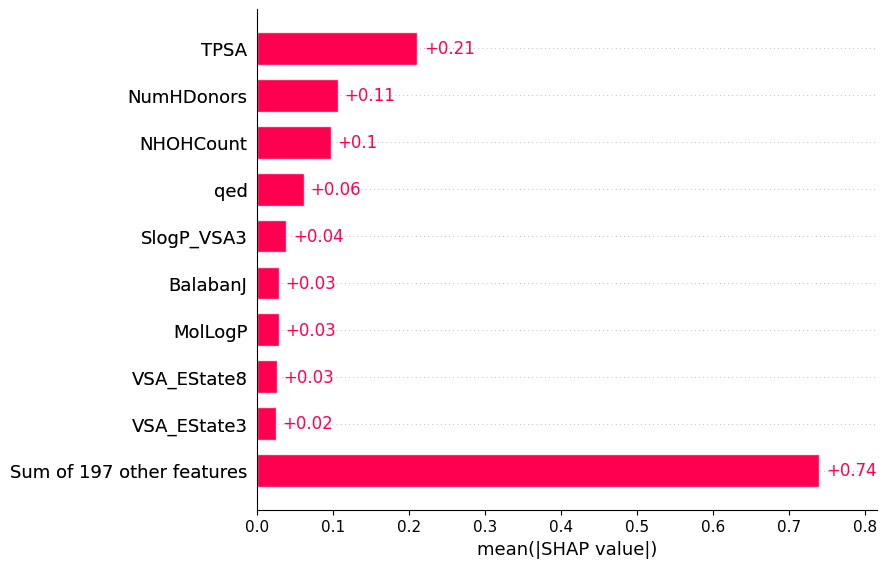

In [22]:
shap.plots.bar(shap_values)

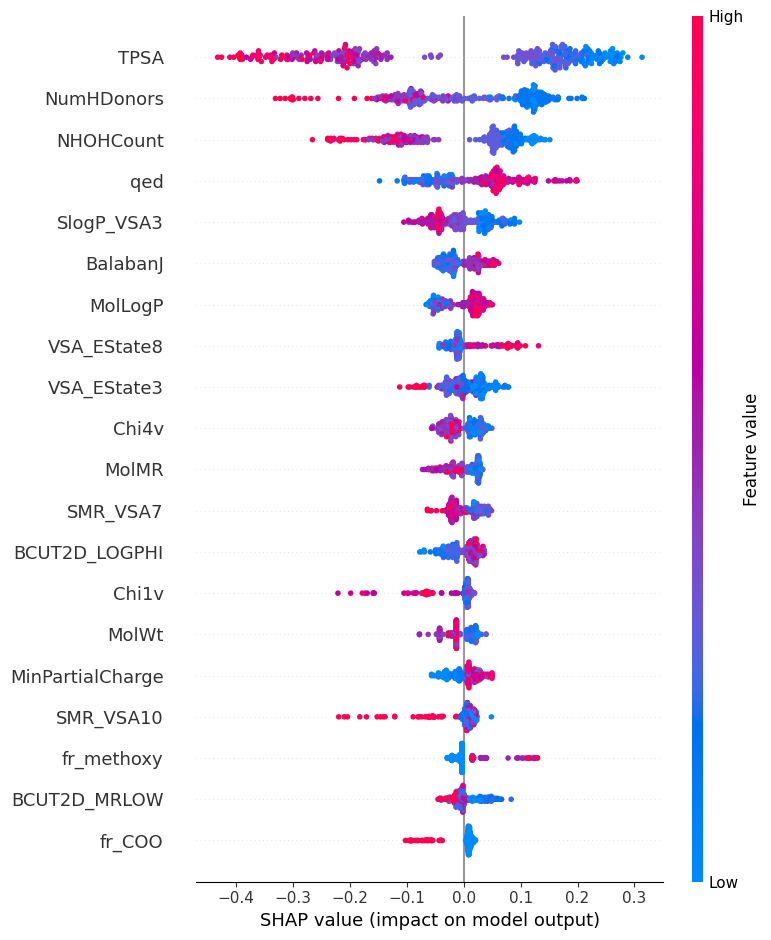

In [23]:
shap.summary_plot(shap_values)

In [25]:
# Shap analysis (Mordred)
model = joblib.load('./Trained Models/LightGBM/Mordred Descriptors/mordred_wc_trained_model_repeat_0.pkl')
explainer = shap.TreeExplainer(model)
shap_values = explainer(test_mordred_wc.drop(columns=['SMILES', 'logPapp']))

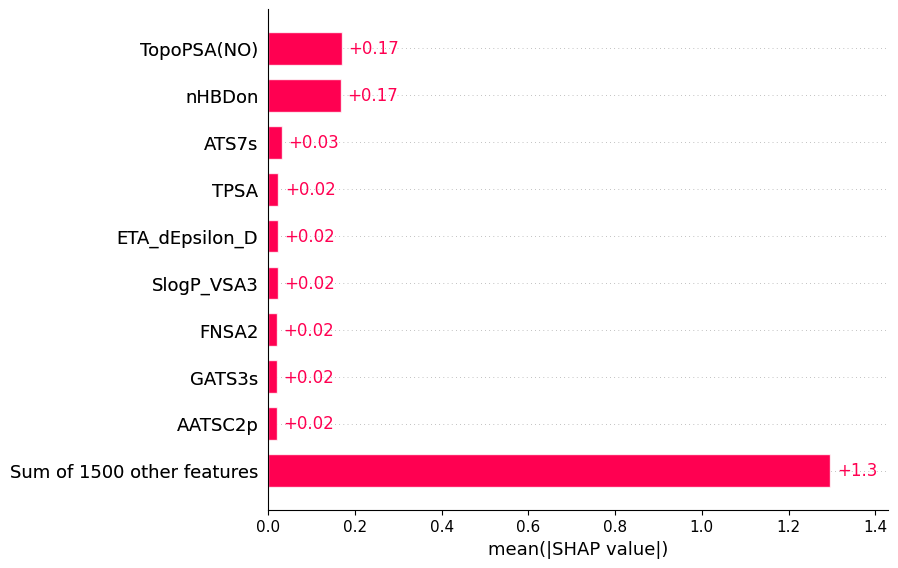

In [26]:
shap.plots.bar(shap_values)

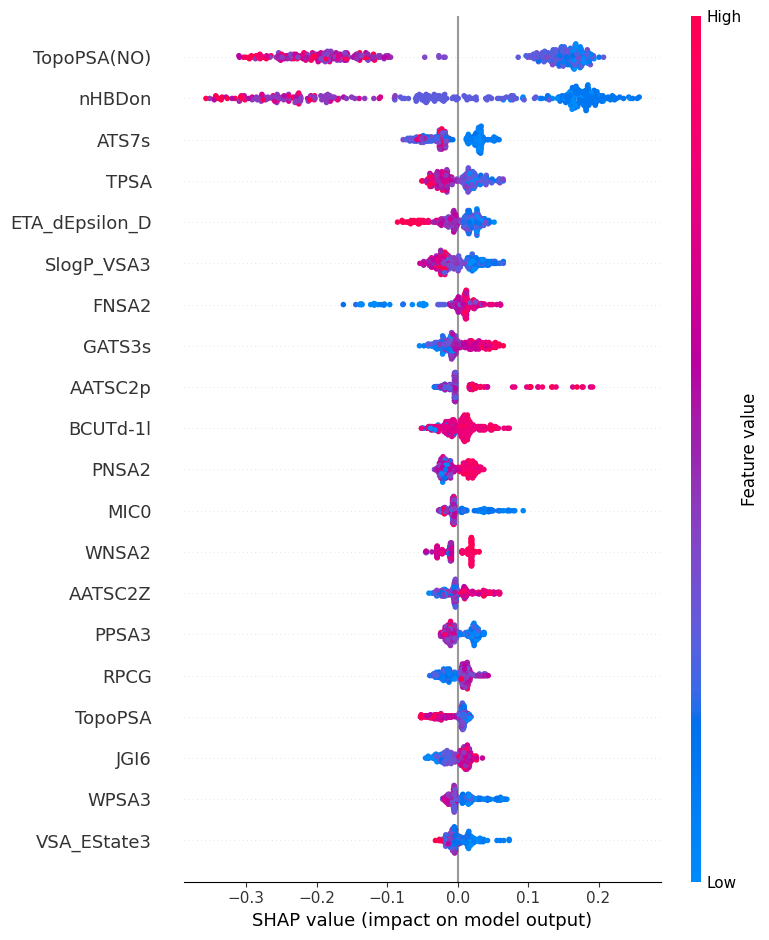

In [27]:
shap.summary_plot(shap_values)

In [36]:
# Shap analysis (Mordred 3D)
model = joblib.load('./Trained Models/LightGBM/Mordred Descriptors/mordred_3D_wc_trained_model_repeat_0.pkl')
explainer = shap.TreeExplainer(model)
shap_values = explainer(test_mordred_3D_wc.drop(columns=['SMILES', 'logPapp']))

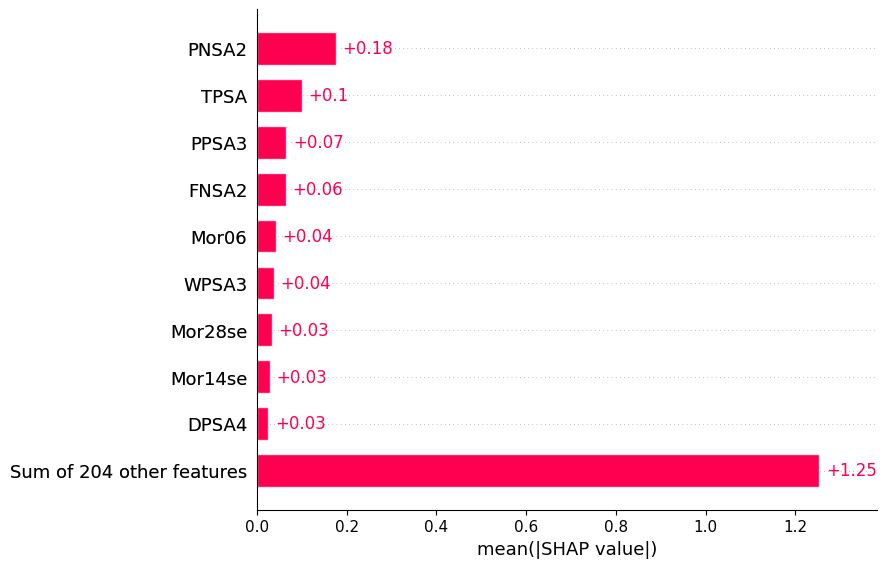

In [37]:
shap.plots.bar(shap_values)

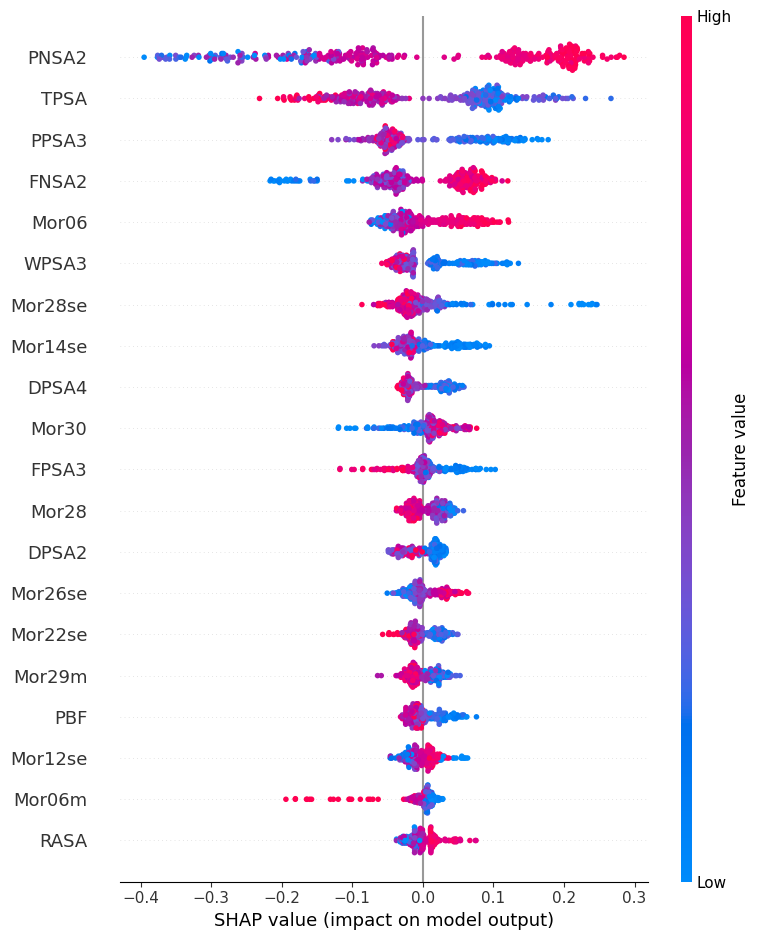

In [38]:
shap.summary_plot(shap_values)